# Intro:

This notebook is the third in the series for the Capstone Project.  "Capstone_Data-Prep" covers pulling in several
data sources, trimming to the needed observations/variables, joining together, and producing the source data or this
notebook.

The second notebook "Capstone_LS_Model" covers the majority of feature selection.

In [285]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings
import json
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import plotly.express as px
import plotly.io as pio

#sklearn Data Prep:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
#from sklearn.feature_selection import SequentialFeatureSelector

#sklearn Imputer:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# SkLearn Measurement Libraries:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import get_scorer


# SkLearn Models

from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble

# set Theme
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

In [286]:
# Set Paths
path = os.getcwd()
sourceDataPath = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/CleanData/'
exportPath = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/Severity/'
plotLoc = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/Severity/'

# set plot export paths:

print(f"Source Data:",sourceDataPath)
print(f"Exports:",exportPath)
print(f"Plots:",plotLoc)

Source Data: C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/CleanData/
Exports: C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/Severity/
Plots: C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/Severity/


In [287]:
#Create Dict of Rename Columns
colsRename = {'st_prc_end':'Stock-End-Price',
              'seq':'Stockholders-Equity-Parent',
              'gp':'Gross-Profit',
              'rest_count':'Number-Of-Restatements',
              'xsga':'Administrative-Expense',
              'epsfi':'Earnings-Share-Diluted',
              'dcpstk':'Convertible-Debt_Pref-Stock',
              'xsga_std':'Administrative-Expense',
              'bkvlps':'Book-Value-Per-Share',
              'esubc':'Equity-in-Net-Loss',
              'dlc': "Debt-Current-Liabilities",
              'oancf': 'Operating-Act_Net-Cash-Flow',
              'rest_sum_diff':'Restatement-Sum-Diffs',
              'ch':'Cash',
              'fincf':'Financing-Act_Net-Cash-Flow',
              'prca':'Post-Retirement-Adj',
              'nopi':'Nonoperating-Inc',
              'aoloch':'Assets-Liabilities-Other-Net-Change',
              'dp':'Depreciation-Amortization',
              'caps':'Capital-Surplus',
              'intan':'Intangible-Assets',
              'mii':'Noncontrolling-Interest',
              'st_per_currentToMax':'Stock-Perc_Curr-To-Max',
              'sec_ajexm':'Cum-Adjust-Factor-Monthly',
              'revt':'Revenue-Total',
              'xint':'Interest-Related-Exp',
              'capx':'Capital-Exp',
              'cibegni':'Comp-Inc_Beg-Net-Inc',
              'invch':'Inventory-Decrease',
              'st_volatility':'Stocks-Volatility',
              'rat_spcsrc':'SP-Quality-Ranking',
              'dltt':'Long-Term-Debt',
              're':'Retained-Earnings',
              'intpn':'Interest-Paid',
              'pi':'Pretax-Inc',
              'sppiv':'Sale-Prop-Plant-Equip-Inv',
              'sec_trfm_mean':'Mthly-Tot-Return-Factor',
              'cshpri':'Comm-Shares_Calc-EPS',
              'tstk':'Treasury-Stock-Tot',
              'opeps':'EPS_from-Ops',
              'wcap':'Working-Capital',
              'sec_trt1m_mean':'Mthly-Tot-Return',
              'ceqt':'Comm-Equity-Tangible',
              'chech':'Cash-Equiv',
              'cogs':'Cost-of-Goods-Sold',
              'ci':'Comp-Income-Tot',
              'dltr':'Long-Term-Debt-Red',
              'spce':'SP-Core-Earnings',
              'rest_count_of_diffs':'Restatement_Cnt-Of-Diffs',
              'st_per_growth':'Stocks-Per-Growth',
              'xacc':'Accrued-Exp',
              'teq':'Stockholders-Equity-Tot',
              'epspi':'Earnings-Per-Share-Basic'
              }

# Reusable Functions:

In [288]:
#statRow = []
cleanActionsDF = pd.DataFrame(columns = ['DF','ActionDesc','List-of-Cols','ResultShape'])

def cleanActionsReport (df,df_name,actionDesc, cols):
    # Collect Stats
    row =[]
    actionDesc = actionDesc
    listCols = cols
    resultShape = df.shape
    # Collect Results
    row = [df_name,actionDesc, listCols, resultShape]
    # append stats to Summary Stats DF
    df = cleanActionsDF
    df_length = len(df)
    df.loc[df_length] = row
    return df

In [289]:
# Takes a DF and Producecs a Report of Null Values
def nullAnalysis(df):
    row = []
    null_summaryDF = pd.DataFrame(columns = ["Variable","Observations","Nulls","Null_Per",
                                             "Num_Unique","Type"])
    for column in df:
        var = column
        countOfObs = len(df[var])
        countOfNull = df[var].isnull().sum()
        perOfNull = round((100 * countOfNull) / countOfObs,3)
        numUnique = df[var].nunique()
        type  = df[var].dtypes
        # Append to Summary DF
        row = [var, countOfObs,countOfNull,perOfNull,numUnique,type]
        df_length = len(null_summaryDF)
        null_summaryDF.loc[df_length] = row
    # Get Summary Stats
    countofVars = len(null_summaryDF)
    countofNotNull = (null_summaryDF['Nulls'] == 0).sum()
    countofNull = (null_summaryDF['Nulls'] != 0).sum()
    print(f"Count of Variables:",countofVars)
    print(f"Count of Variables without nulls:",countofNotNull)
    print(f"Count of Variables with null :",countofNull)
    # Format Summary
    summaryDF = null_summaryDF[null_summaryDF['Nulls'] != 0].sort_values(by=['Nulls'],ascending=False)
    return summaryDF

In [290]:
#  Split function - Takes a df and list of predictor vars and specified response var and
##  returns x/y test/train sets.
## Note: update params if you want reproducable splits or not
## Note: set test size to 20%

def testTrainSplit (df, PredictorVar,ResponseVar):
    # Split into training/test
    x = df[PredictorVar]
    y = df[ResponseVar]
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.35)
    return x_train, x_test, y_train, y_test



In [291]:
# Create DF To Hold Summary Stats
statRow = []
quantStats = pd.DataFrame(columns = ["Model","RegType","R2_Score","MSE","RMSE"])

def summaryStats_quant(model,y_test,y_pred,SummaryDF):
    regType = model
    row =[]
    Score = r2_score(y_test,y_pred)
    MSE = round(mean_squared_error(y_test,y_pred),4)
    RMSE = np.sqrt(MSE)
    # Append to Summary DF
    df = SummaryDF
    row = [model,regType,Score,MSE,RMSE]
    df_length = len(df)
    df.loc[df_length] = row
    return Score, MSE, RMSE

In [292]:
def edited_prepVarsForMLR(df, dependent_var):
    columns = df.columns.values.tolist()
    columns.remove(dependent_var)
    return dependent_var + '~' + '+'.join(columns)


In [293]:
def prepVarsForMLR(df, dependent_var,*varsToRemove):
    columns = list(df.columns.values)
    columns.remove(dependent_var)
    for col in varsToRemove:
        columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(columns)

In [294]:
#guide: https://towardsdatascience.com/backward-elimination-for-feature-selection-in-machine-learning-c6a3a8f8cef4
# Take P_Value of the F-static

def backwardElimination(df,respVar,signLevel):
    origFeatList = df.columns.values.tolist()
    origFeatList.remove(respVar)
    # Create df for significant features:
    nonsignFeatDF = pd.DataFrame(columns = ['feature','pvalue'])
    ##### Start Loop ########
    x = df.shape[1]
    while x > 0:
        tempdf = df
        # For feature in list of features get p
        listofVars = prepVarsForMLR(tempdf,respVar) # Prep Vars for OLS p-value:
        ols = smf.ols(formula=listofVars, data=df).fit() # fit model
        # get pvalues
        ## Make DF w/ P Values
        pvalueDF = pd.DataFrame(ols.pvalues).reset_index()
        pvalueDF = pvalueDF.rename(columns={'index':'feature',0:'pvalue'})
        pvalueDF = pvalueDF.iloc[1: , :] ## Drop first Row which is always the intercept
        ## Select Feature w/ Highest P-Value
        checkmaxP = pvalueDF['pvalue'].max()
        ## If PValue is greater that Sign-Level
        if checkmaxP >= signLevel:
            # Add Feature/PValue to SignFeatureDF
            maxP = pvalueDF[pvalueDF.pvalue == pvalueDF.pvalue.max()]
            nonsignFeatDF = pd.concat([nonsignFeatDF,maxP], ignore_index=True)
            # Remove Feature From DF
            #varToRemove = maxP['feature'].values.tolist() #get feature name as a string to remove
            #df = df.drop(columns=varToRemove)
            # Update x
            x=x-1
        else:
            x=0
            signFeatList = pvalueDF['feature'].values.tolist()
    return nonsignFeatDF, signFeatList


In [295]:
# Takes a model and returns a Feature Importance Plot

def FeatureImportance (model,featureList):
    # Best Tree-- Plot Most Important Features
    importances = model.feature_importances_
    #Convert Array to DF
    feature_importances = pd.Series(importances, index=featureList)
    feature_importances = feature_importances.to_frame().reset_index()
    feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
    feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
    #std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)
    # Create Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize = (6,6), dpi=200)
    ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Impurity Decrease")
    fig.tight_layout()
    return feature_importances, fig

In [296]:
def quickModelComparison_quant(models,qe_x_train,qe_x_test, qe_y_train,qe_y_test, qe_summaryDF):
    i=0
    for model in models:
        # Model Name
        model_name = str(models[i])
        split_string = model_name.split("(", 1)
        model_name = split_string[0]
        i=i+1
        #fit
        model.fit(qe_x_train,qe_y_train)
        # Make Predictions
        y_pred_qe = model.predict(qe_x_test)
        # summary
        quantStats = summaryStats_quant(model_name, qe_y_test, y_pred_qe,qe_summaryDF)
    return qe_summaryDF

In [297]:
def z_score(df,scaleList):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in scaleList:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        df_std[column] = round(df_std[column],5)
    return df_std



# Get & Prep Data

In [298]:
## Get Data from after LS_Modeling Feature Selection + Imputing + Scaling
file = 'Clean_Modeling_Data.xlsx'
ModelingDF_orig = pd.read_excel(sourceDataPath+file)
ModelingDF_orig = ModelingDF_orig.drop(columns=['Unnamed: 0'])
ModelingDF_orig = ModelingDF_orig.rename(columns={'SettlementAmount':'severity'})
ModelingDF_orig = ModelingDF_orig.set_index('gvkey')

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Original Shape"
df_name = "ModelingDF_orig"
cols = "All"
cleanActionsReport(ModelingDF_orig,df_name,cleanActionsDesc,cols)

print(ModelingDF_orig.shape)
ModelingDF_orig.sample(3)



(348, 161)


,exesign,src,auop,aoloch,aoloch_std,at,at_std,bkvlps,bkvlps_std,caps,...,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trfm_std,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit,severity,Dismissed
gvkey,,,,,,,,,,,,,,,,,,,,,
30436,1,53,1,-0.05,-0.18,-0.22,0.29,-0.08,-0.08,-0.13,...,-0.13,-0.13,0.09,-0.02,-0.13,-0.15,0,0,nan,NaN
178859,1,53,2,-0.06,-0.24,-0.34,-0.02,-0.08,-0.08,-0.22,...,-0.31,-0.31,-0.30,-0.23,-0.08,-0.07,0,0,nan,NaN
137884,1,5,2,-0.06,-0.39,-0.34,-0.38,-0.08,-0.08,-0.21,...,-0.13,-0.13,-0.30,-0.23,-0.10,-0.05,2,0,nan,NaN


In [299]:
# Drop All Columns w/ STD suffix.  They were meaningful for classification, but regression should use Median
ModelingDF_orig = ModelingDF_orig.drop(ModelingDF_orig.filter(regex='_std').columns, axis=1)
ModelingDF_orig

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Dropped Standard Deviation Columns - Median More Meaningful to Regression"
df_name = "ModelingDF"
cols = "All STD Columns"
cleanActionsReport(ModelingDF_orig,df_name,cleanActionsDesc,cols)

print(ModelingDF_orig.shape)
ModelingDF_orig.sample(3)

(348, 89)


,exesign,src,auop,aoloch,at,bkvlps,caps,capx,ceq,ceqt,...,st_per_lowToStart,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trt1m_mean,rat_spcsrc,lawsuit,severity,Dismissed
gvkey,,,,,,,,,,,,,,,,,,,,,
187581,0,88,2,-0.07,-0.33,-0.07,-0.22,-0.28,-0.28,0.01,...,-0.49,0.65,0.03,0.11,-0.03,0.05,0,0,nan,NaN
13456,1,5,2,-0.06,-0.34,-0.08,-0.22,-0.28,-0.30,-0.01,...,-1.00,1.36,-0.13,-0.13,-0.30,-0.23,0,0,nan,NaN
8815,1,5,1,-0.12,0.27,-0.08,-0.34,0.44,0.58,1.39,...,-0.86,0.97,-0.13,-0.13,-0.27,-0.15,7,0,nan,NaN


In [300]:
# Create Working Copy of ModelingDF -- Will need to go back to this to get BBC
ModelingDF = ModelingDF_orig.copy()

In [301]:
# Create Report For Starting Statics -- part 1
print("companies who faced lawsuit:\n",ModelingDF['lawsuit'].value_counts())

companies who faced lawsuit:
 0    302
1     46
Name: lawsuit, dtype: int64


In [302]:
## Drop Rows Where Lawsuit is 0
print(f"Count of Null Settlements:",ModelingDF['severity'].isna().sum(),"-- Original Shape:",ModelingDF.shape)
ModelingDF = ModelingDF[ModelingDF['lawsuit']==1]
print(f"Count of Null Settlements:",ModelingDF['severity'].isna().sum(),"-- Remaining Shape:",ModelingDF.shape)

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Rows w/ Null Settlement"
df_name = "ModelingDF"
cols = "All"
cleanActionsReport(ModelingDF,df_name,cleanActionsDesc,cols)

print(ModelingDF.shape)

Count of Null Settlements: 337 -- Original Shape: (348, 89)
Count of Null Settlements: 35 -- Remaining Shape: (46, 89)
(46, 89)


In [303]:
nullAnalysisDF = nullAnalysis(ModelingDF)
nullAnalysisDF

Count of Variables: 89
Count of Variables without nulls: 88
Count of Variables with null : 1


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
87,severity,46,35,76.09,11,float64


In [304]:
# Create Report For Starting Statics -- part 2
print("Lawsuit Status Overview")
print(ModelingDF['Dismissed'].value_counts())

# Create Report For Starting Statics -- part 2
print("Severity")
print(ModelingDF['severity'].value_counts(dropna=False))

Lawsuit Status Overview
Yes        18
Ongoing    18
No         10
Name: Dismissed, dtype: int64
Severity
nan            35
2200000.00      1
2700000.00      1
6000000.00      1
47500000.00     1
1500000.00      1
6750000.00      1
5750000.00      1
3750000.00      1
11250000.00     1
11000000.00     1
9000000.00      1
Name: severity, dtype: int64


In [305]:
## Drop Rows Where Settlement is Null
print(f"Count of Null Settlements:",ModelingDF['severity'].isna().sum(),"-- Original Shape:",ModelingDF.shape)
ModelingDF = ModelingDF[ModelingDF['severity'].notnull()]
print(f"Count of Null Settlements:",ModelingDF['severity'].isna().sum(),"-- Remaining Shape:",ModelingDF.shape)


Count of Null Settlements: 35 -- Original Shape: (46, 89)
Count of Null Settlements: 0 -- Remaining Shape: (11, 89)


In [306]:
# Create Report For Starting Statics -- part 3
print("Severity Count for Remaining Observations:")
print(ModelingDF['severity'].value_counts())
print()
print("Dismissed Status  for Remaining Observations:")
print(ModelingDF['Dismissed'].value_counts())
print()
ModelingDF['severity'].describe(percentiles=[.25, .5,.75,.95]).apply(lambda x: format(x, 'f'))


Severity Count for Remaining Observations:
2200000.00     1
5750000.00     1
11000000.00    1
47500000.00    1
2700000.00     1
1500000.00     1
6750000.00     1
11250000.00    1
9000000.00     1
3750000.00     1
6000000.00     1
Name: severity, dtype: int64

Dismissed Status  for Remaining Observations:
No     10
Yes     1
Name: Dismissed, dtype: int64



count          11.000000
mean      9763636.363636
std      12958647.516409
min       1500000.000000
25%       3225000.000000
50%       6000000.000000
75%      10000000.000000
95%      29375000.000000
max      47500000.000000
Name: severity, dtype: object

In [307]:
# Drop Dismissed
# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Lawsuit & Dismissed"
df_name = "ModelingDF"
cols = "Lawsuit/ Dismissed"

colsToDrop = ['lawsuit','Dismissed']

ModelingDF = ModelingDF.drop(columns=colsToDrop)
cleanActionsReport(ModelingDF,df_name,cleanActionsDesc,cols)

print(ModelingDF.shape)

(11, 87)


In [308]:
ModelingDF = ModelingDF[ModelingDF['severity'] <= 45000000]
ModelingDF

,exesign,src,auop,aoloch,at,bkvlps,caps,capx,ceq,ceqt,...,st_per_growth,st_per_currentToMax,st_per_lowToStart,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trt1m_mean,rat_spcsrc,severity
gvkey,,,,,,,,,,,,,,,,,,,,,
3505,1,53,1,-0.42,0.40,-0.08,0.60,-0.02,0.68,0.09,...,0.59,0.95,-0.17,0.14,-0.13,-0.13,-0.24,-0.13,5,6000000.00
5301,1,5,2,-0.40,-0.20,-0.08,-0.10,-0.19,-0.41,-0.24,...,-0.97,0.02,-1.00,1.08,-0.13,-0.13,0.25,-0.21,1,9000000.00
7691,1,5,1,-0.08,-0.28,-0.08,-0.19,-0.21,-0.26,0.03,...,-0.25,0.63,-0.50,0.25,-0.13,-0.13,0.31,-0.14,3,6750000.00
12785,1,5,2,0.17,-0.18,-0.08,0.13,-0.14,-0.18,0.18,...,2.40,1.00,-0.67,0.57,-0.13,-0.13,-0.23,-0.11,3,1500000.00
20327,0,88,1,-0.06,-0.34,-0.13,-0.20,-0.28,-0.30,-0.01,...,5.21,0.62,-0.39,0.71,0.00,-0.00,-0.00,0.02,0,5750000.00
112968,1,5,1,-0.03,-0.34,-0.08,-0.21,-0.28,-0.30,-0.01,...,2.98,0.35,-0.88,1.00,-0.43,-0.43,-0.25,-0.13,2,11250000.00
114959,1,5,1,-0.05,-0.33,-0.08,-0.19,-0.25,-0.29,0.01,...,-1.00,0.00,-1.00,1.30,-0.13,-0.13,-0.30,-0.16,0,2700000.00
149379,1,5,1,-0.06,-0.33,-0.08,-0.21,-0.27,-0.29,0.01,...,-0.69,0.16,-0.71,0.55,-0.13,-0.13,-0.30,-0.14,0,2200000.00
163627,1,5,1,-0.08,-0.27,-0.08,-0.15,-0.26,-0.26,-0.11,...,-0.19,0.29,-0.63,0.51,-0.13,-0.13,-0.29,-0.13,0,11000000.00


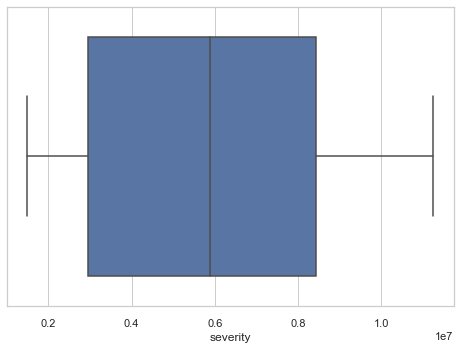

In [309]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=ModelingDF['severity'])

## LawSuit Modeling -- Feature Selection and Prepare Data

Process:
* Check Correlation w/ Response Var
* Check Collinearity
* Use RF/GB Feature Importance
* Create Resulting Feature List

####  Severity Modeling -- Feature Selection -- Best Subset Selection -- Backward Elimination


<AxesSubplot:xlabel='severity', ylabel='Density'>

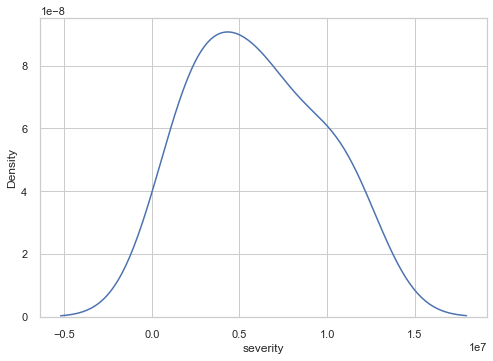

In [310]:
# plot severity distribution

sns.kdeplot(data=ModelingDF, x="severity")

### LawSuit Modeling -- Feature Selection -- Check Correlation

In [311]:
# Feature Selection -- Check Correlation -- Correlation with output variable
responseVar = 'severity'
cor = round(ModelingDF.corr(),3)
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
nonRelevant_features = cor_target[cor_target<0.05] # Look for Features w/ less 0.05 cor
nonRelevant_features


exesign             0.02
src                 0.02
at                  0.00
bkvlps              0.02
ch                  0.03
dltt                0.00
dp                  0.04
dpact               0.04
dvc                 0.01
dvt                 0.00
esopct              0.02
esubc               0.03
icapt               0.05
ivncf               0.04
lse                 0.00
nopi                0.01
ppegt               0.04
re                  0.03
revt                0.02
siv                 0.01
tot_tax             0.03
xopr                0.02
st_per_lowToStart   0.04
rat_spcsrc          0.04
Name: severity, dtype: float64

In [312]:
## Feature Selection -- Check Correlation -- Trim DF to Relevant Features

# List of features to drop
nonRelevant_features = nonRelevant_features.index.values.tolist()
# Override
overrideCols = []
for col in overrideCols:
    nonRelevant_features.remove(col)

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Features with less than 0.05 corr while making sure to have 1 feature per source"
df_name = "ModelingDF"

ModelingDF = ModelingDF.drop(columns=nonRelevant_features)
cleanActionsReport(ModelingDF,df_name,cleanActionsDesc,nonRelevant_features)

# Resulting DF
print(ModelingDF.shape)
ModelingDF.sample(3)

(10, 63)


,auop,aoloch,caps,capx,ceq,ceqt,chech,ci,cibegni,cogs,...,rest_count_of_diffs,st_prc_end,st_per_growth,st_per_currentToMax,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trt1m_mean,severity
gvkey,,,,,,,,,,,,,,,,,,,,,
178795,1,-0.03,-0.14,-0.27,-0.28,-0.00,-0.15,-0.29,-0.29,-0.23,...,0,-0.22,-0.60,0.39,0.31,-0.13,-0.13,-0.30,-0.14,3750000.00
5301,2,-0.40,-0.10,-0.19,-0.41,-0.24,0.23,-0.73,-0.72,0.02,...,2,-0.23,-0.97,0.02,1.08,-0.13,-0.13,0.25,-0.21,9000000.00
114959,1,-0.05,-0.19,-0.25,-0.29,0.01,-0.10,-0.30,-0.31,-0.25,...,0,-0.23,-1.00,0.00,1.30,-0.13,-0.13,-0.30,-0.16,2700000.00


In [313]:
df = ModelingDF
respVar = 'severity'
signLevel = 0.05

sev_nonsignFeatDF, sev_signFeatList = backwardElimination(df,respVar,signLevel)
print(f"signifant features:",sev_signFeatList)
sev_nonsignFeatDF


signifant features: ['auop', 'aoloch', 'caps', 'capx', 'ceq', 'ceqt', 'chech', 'ci', 'cibegni', 'cogs', 'cshpri', 'dcpstk', 'defrev', 'dilavx', 'dlc', 'dltr', 'ebit', 'epsfi', 'epsfx', 'epspi', 'fincf', 'fopo', 'gdwl', 'gp', 'intan', 'intpn', 'invch', 'invt', 'lct', 'lt', 'mii', 'msa', 'ni', 'np', 'oancf', 'opeps', 'pi', 'pnca', 'prca', 'pstk', 'rect', 'seq', 'spce', 'sppiv', 'sstk', 'teq', 'tstk', 'wcap', 'xacc', 'xint', 'xsga', 'rest_count', 'rest_sum_diff', 'rest_count_of_diffs', 'st_prc_end', 'st_per_growth', 'st_per_currentToMax', 'st_volatility', 'sec_ajexm', 'sec_ajpm', 'sec_trfm_mean', 'sec_trt1m_mean']


,feature,pvalue


###  Severity Modeling -- Feature Selection -- Use Rand Forest Regressor Feature Importance
* Creates a Test/Train Split (Will Resplit from Source After Feature Selection)
* Then uses Random Forest and Grad Boost for Feature Importance
* Results reflected in feature lists for model and stored as reports
and plots in the export directory

In [314]:
# Set or Reset Test/Train Split
# Params
df=ModelingDF
ResponseVar = 'severity'
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)
print(f"x_train shape:",x_train.shape)
print(f"x_test shape:",x_test.shape)


x_train shape: (6, 62)
x_test shape: (4, 62)


In [315]:
print("starting RF")
# Random Forest
## Set and Fit Model
## Note: Params from gridSearchCV optimized for recall w/ all features
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

## Make Predictions
y_pred_rf = rf.predict(x_test)
print("done RF")

starting RF
done RF


In [316]:
# Multiple Regression -- Call Summary Function

regType = "RF Regressor -- Feature Selection"
stats_y_test = y_test
stats_y_pred = y_pred_rf
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
print(f'r2 score is: ',Score)
print(f'mean_sqrd_error:',MSE)
print(f'root_mean_squared error:',RMSE)



r2 score is:  -6.906317453580902
mean_sqrd_error: 34929863437500.0
root_mean_squared error: 5910149.18910682


Start RF Feature Importance


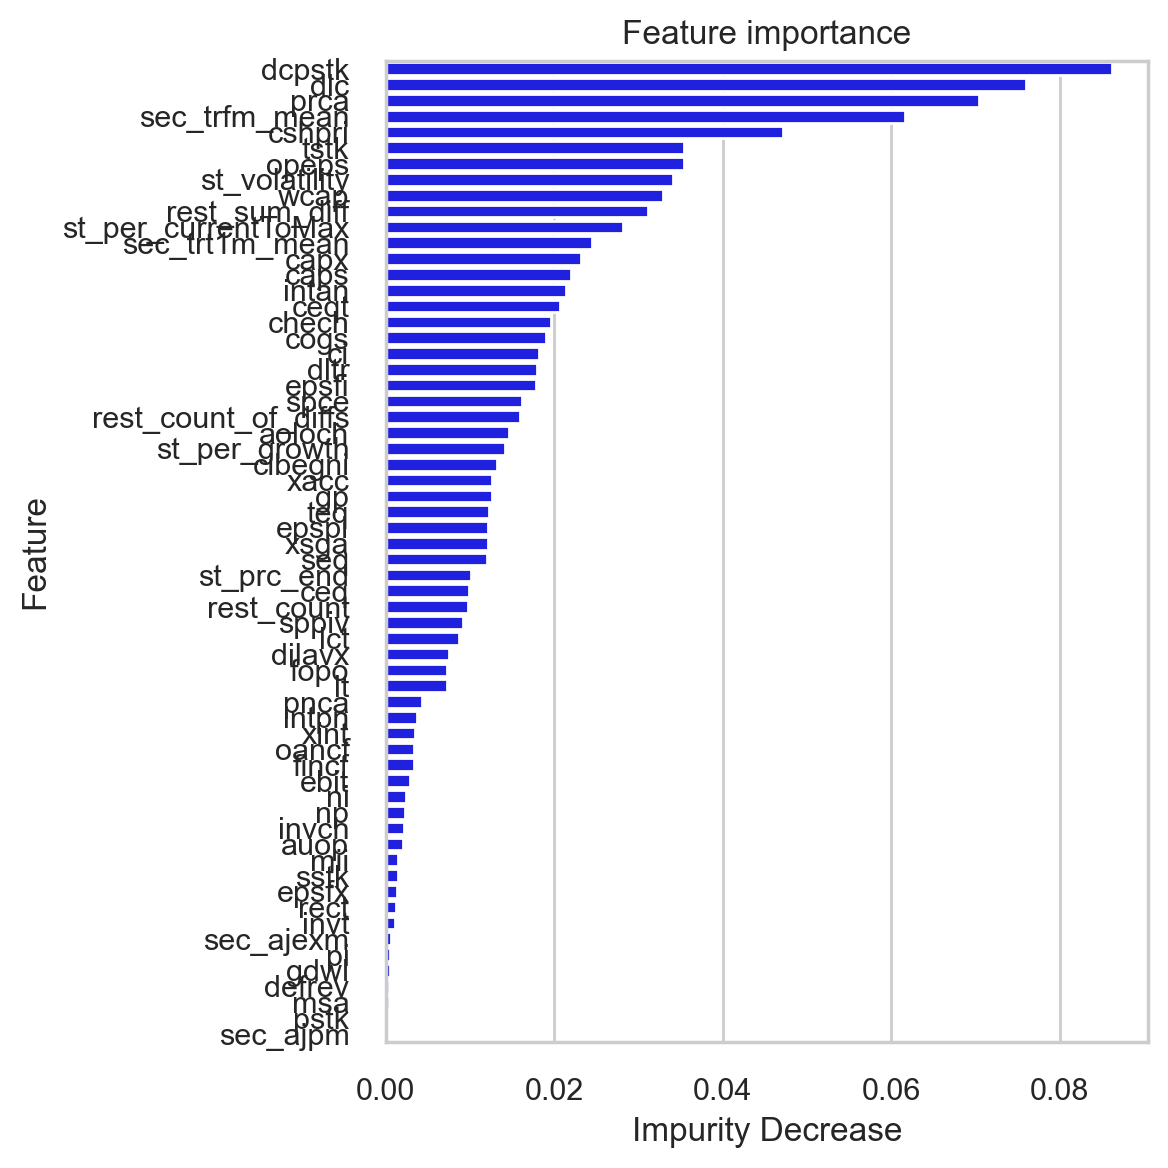

In [317]:
# Random Forest -- Feature Importance -- Plot ALL Features
print("Start RF Feature Importance")
featureList = x_train.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Severity_FeatSelect.png')


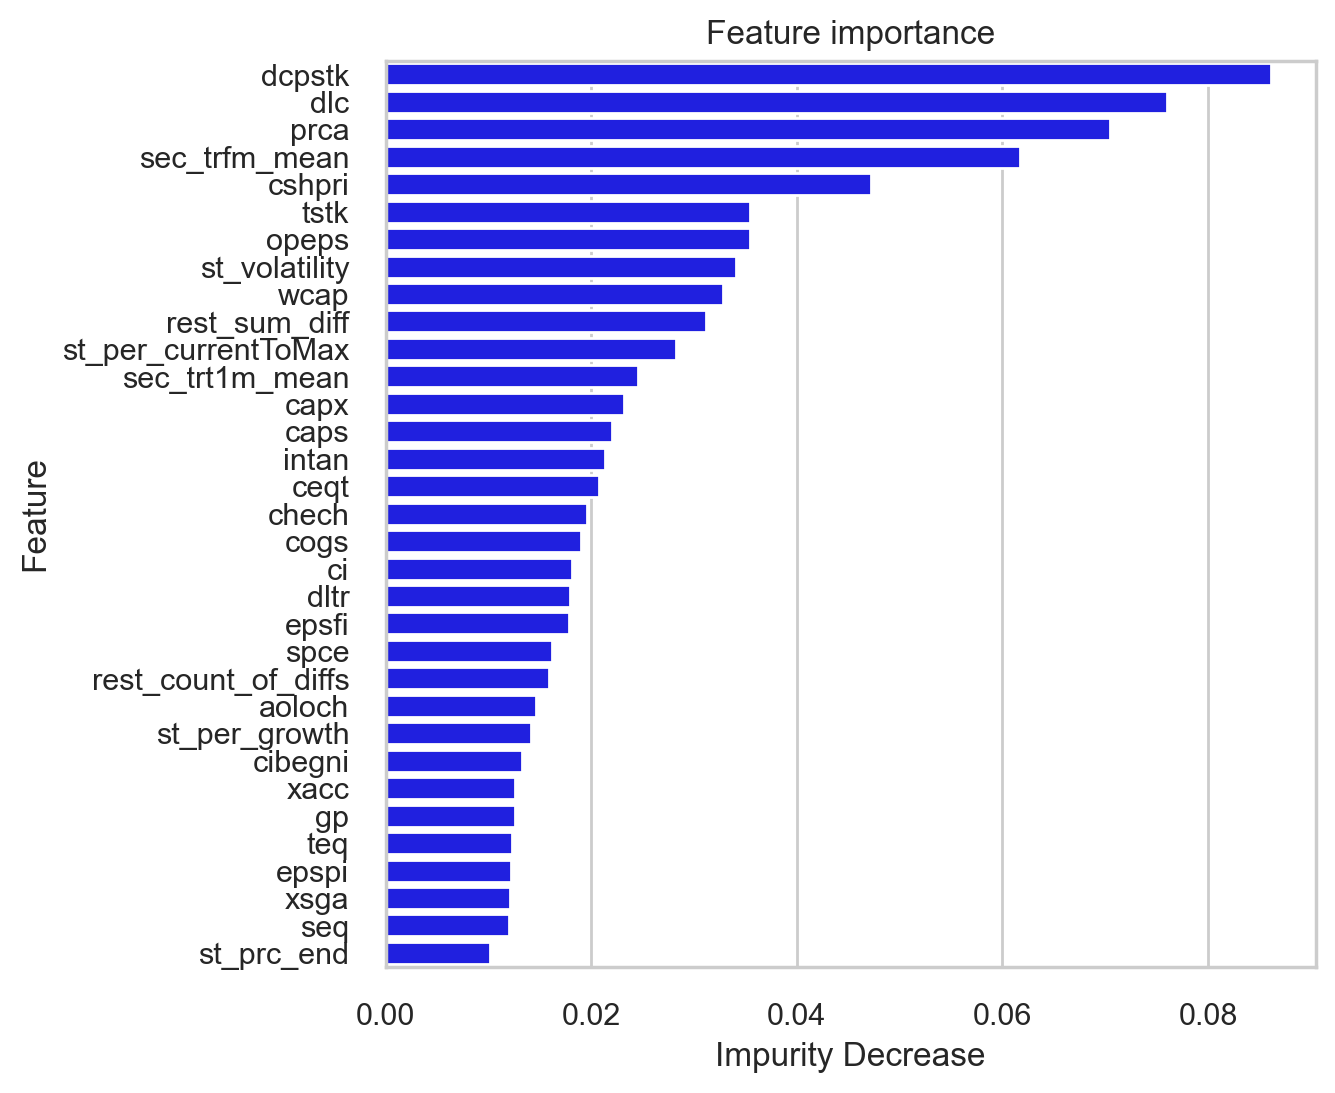

In [318]:
# Random Forest -- Feature Importance -- Plot Most Important Features
# drop these row indexes
# from dataFrame
index_names = feature_importances[feature_importances['impDecrease'] <= 0.01 ].index

# drop these row indexes
# from dataFrame
feature_importances.drop(index_names, inplace = True)
feature_importances

#featImport_ManAppend = {'feature': 'rat_spcsrc', 'impDecrease': 0.001111, 'Model': 'Manual Addition'}
#feature_importances = feature_importances.append(featImport_ManAppend,ignore_index=True)

# Create Plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (6,6), dpi=200)
ax = sns.barplot(x="impDecrease", y="feature",
                  data=feature_importances, color="blue")
#plt.vlines(x = 0.01, ymin = -1, ymax = 17.0, color = 'black', linewidth=1)
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Impurity Decrease")

plt.savefig(plotLoc +'Combined_LS_FeatSelect.png')


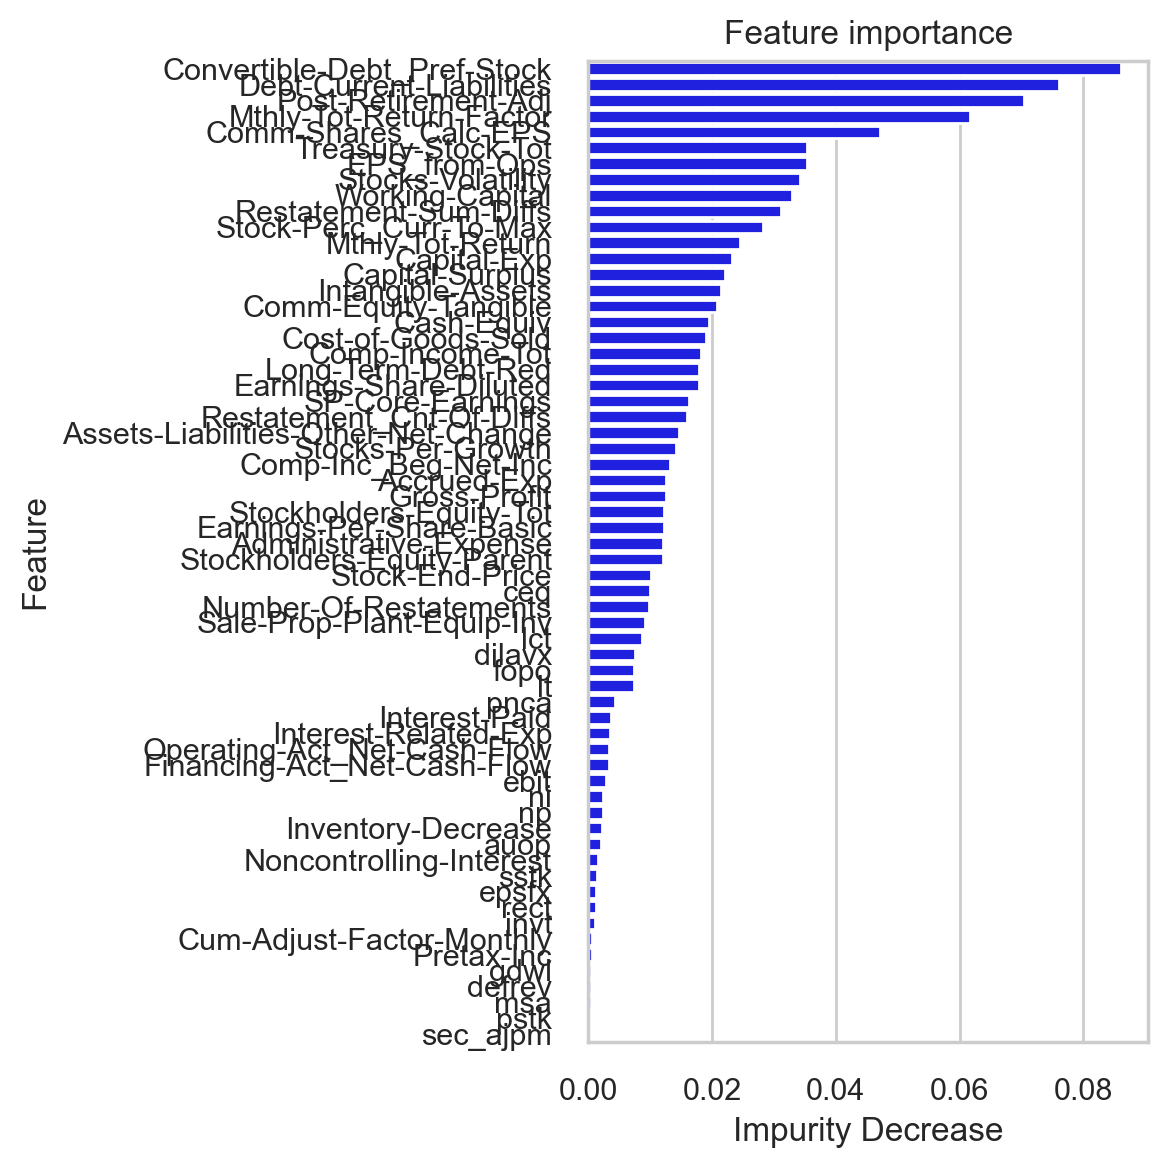

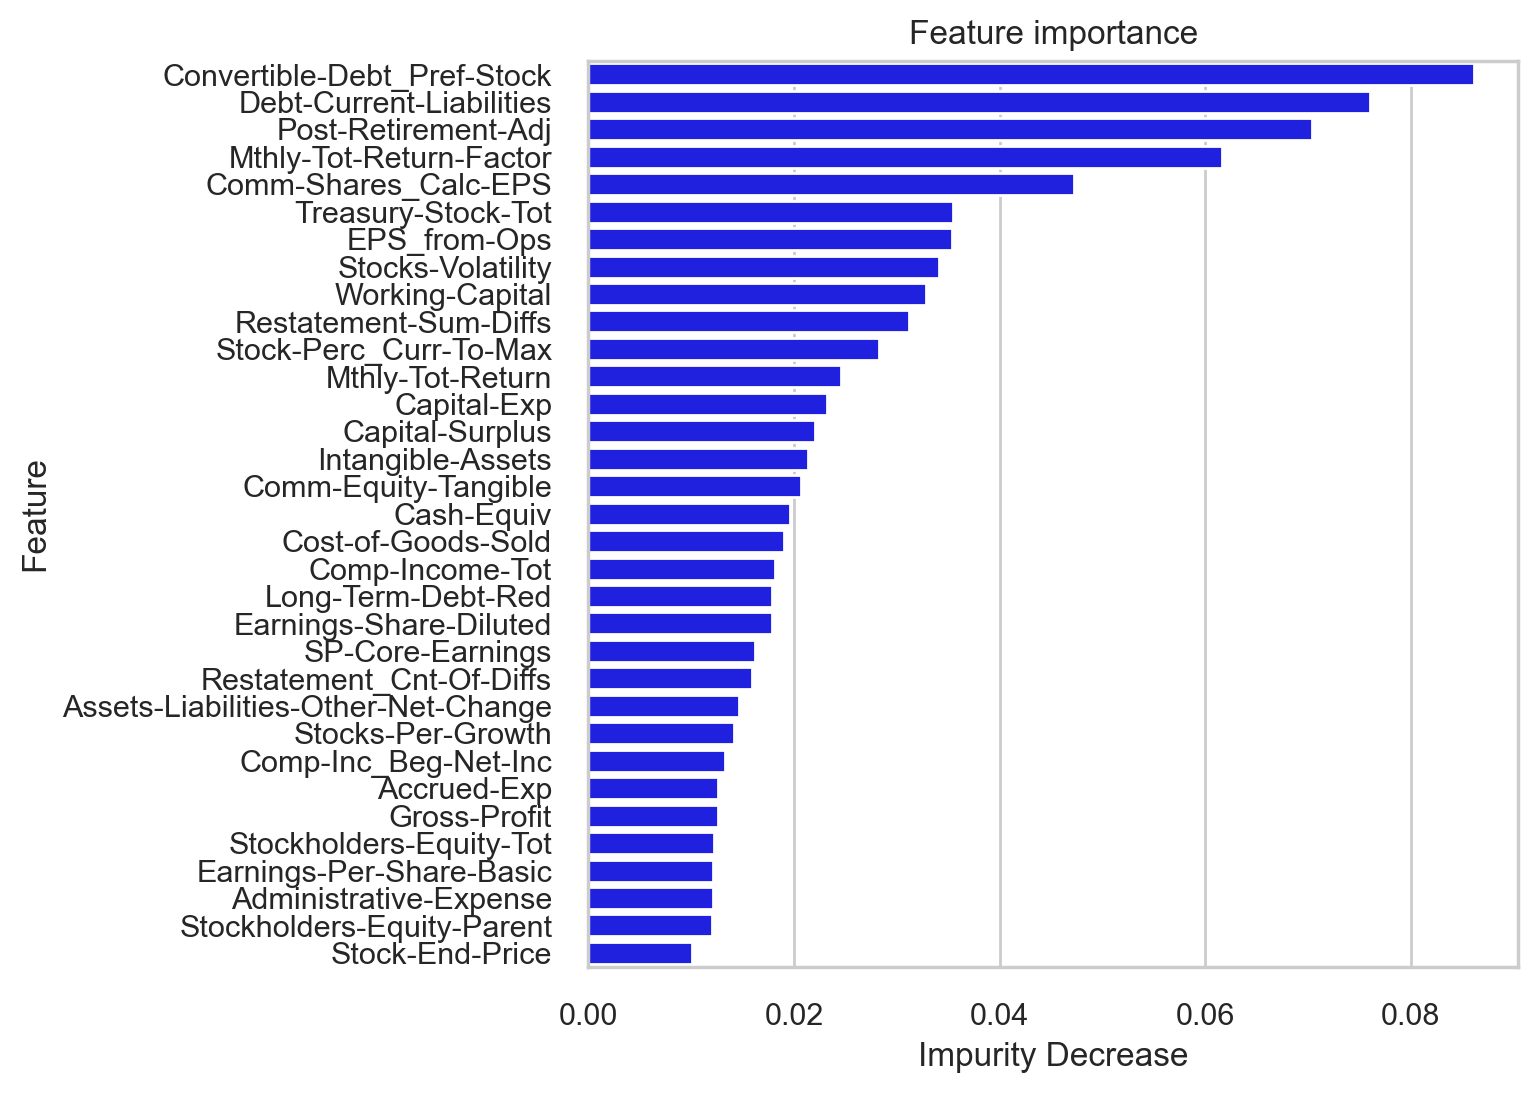

In [319]:
# Create Human Readable Feature Importance Plot
featureListDF = x_train
featureListDF = featureListDF.rename(columns=colsRename)

featureList = featureListDF.columns.to_list()
feature_importances_readable, fig = FeatureImportance(rf,featureList) #model, featureList
feature_importances_readable = feature_importances_readable[feature_importances_readable['impDecrease']>=0.01]

# Create Plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (6,6), dpi=200)
ax = sns.barplot(x="impDecrease", y="feature",
                  data=feature_importances_readable, color="blue")
#plt.vlines(x = 0.01, ymin = -1, ymax = 17.0, color = 'black', linewidth=1)
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Impurity Decrease")

plt.savefig(plotLoc+'RF_Feature-Importance_For-Report.png')

In [320]:
# Feature Selection -- make list of features
selectedFeatures = feature_importances.copy()
selectedFeatures = selectedFeatures.drop(columns=['impDecrease'])
selectedFeatures = selectedFeatures['feature'].unique()
selectedFeatures

array(['dcpstk', 'dlc', 'prca', 'sec_trfm_mean', 'cshpri', 'tstk',
       'opeps', 'st_volatility', 'wcap', 'rest_sum_diff',
       'st_per_currentToMax', 'sec_trt1m_mean', 'capx', 'caps', 'intan',
       'ceqt', 'chech', 'cogs', 'ci', 'dltr', 'epsfi', 'spce',
       'rest_count_of_diffs', 'aoloch', 'st_per_growth', 'cibegni',
       'xacc', 'gp', 'teq', 'epspi', 'xsga', 'seq', 'st_prc_end'],
      dtype=object)

In [321]:
# Create Modeling Dataframe for Modeling Lawsuit

# New Feature List (From Re-Run of Feature Import using Recall settings, only used RF Features since Recall was better)
## Feature List Exported as ..."RFONLY"
## Manuall removed features that had multiple versions -- and commented out section below that did that for orig list
sev_featList = ['severity',
                'dcpstk', 'dlc', 'prca', 'sec_trfm_mean', 'cshpri', 'tstk',
                'opeps', 'st_volatility', 'wcap', 'rest_sum_diff',
                'st_per_currentToMax', 'sec_trt1m_mean', 'capx', 'caps', 'intan',
                'ceqt', 'chech', 'cogs', 'ci', 'dltr', 'epsfi', 'spce',
                'rest_count_of_diffs', 'aoloch', 'st_per_growth', 'cibegni',
                'xacc', 'gp', 'teq', 'epspi', 'xsga', 'seq', 'st_prc_end'
               ]

## Create Modeling Dataframe
sev_Modeling = ModelingDF[sev_featList]
## Set gvkey as index
print(sev_Modeling.shape)
sev_Modeling.sample(3)

(10, 34)


,severity,dcpstk,dlc,prca,sec_trfm_mean,cshpri,tstk,opeps,st_volatility,wcap,...,aoloch,st_per_growth,cibegni,xacc,gp,teq,epspi,xsga,seq,st_prc_end
gvkey,,,,,,,,,,,,,,,,,,,,,
178795,3750000.00,-0.19,-0.18,0.05,-0.30,-0.32,-0.19,-0.08,0.31,-0.00,...,-0.03,-0.60,-0.29,-0.26,-0.28,-0.27,-0.09,-0.23,-0.28,-0.22
163627,11000000.00,-0.19,-0.23,-0.01,-0.29,-0.38,-0.19,-0.09,0.51,-0.13,...,-0.08,-0.19,-0.31,-0.27,-0.27,-0.26,-0.11,-0.25,-0.26,-0.08
5301,9000000.00,2.81,-0.23,-0.09,0.25,-0.33,-0.19,-0.28,1.08,0.19,...,-0.40,-0.97,-0.72,-0.18,0.03,-0.39,-0.38,0.20,-0.39,-0.23


In [322]:
# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Features with less than 0.01 impDecrease"
df_name = "sev_Modeling"
remainingCols = sev_featList
cleanActionsReport(sev_Modeling,df_name,cleanActionsDesc,remainingCols)

,DF,ActionDesc,List-of-Cols,ResultShape
0,ModelingDF_orig,Original Shape,All,"(348, 161)"
1,ModelingDF,Dropped Standard Deviation Columns - Median Mo...,All STD Columns,"(348, 89)"
2,ModelingDF,Drop Rows w/ Null Settlement,All,"(46, 89)"
3,ModelingDF,Drop Lawsuit & Dismissed,Lawsuit/ Dismissed,"(11, 87)"
4,ModelingDF,Drop Features with less than 0.05 corr while m...,"[exesign, src, at, bkvlps, ch, dltt, dp, dpact...","(10, 63)"
5,sev_Modeling,Drop Features with less than 0.01 impDecrease,"[severity, dcpstk, dlc, prca, sec_trfm_mean, c...","(10, 34)"


In [323]:
# Backward Elimination -- note that all features were noted as significant by p-value, so other methods were used
## Unusable due to notated bug: https://github.com/statsmodels/statsmodels/issues/4831
df = sev_Modeling
respVar = 'severity'
signLevel = 0.05

sev_nonsignFeatDF, sev_signFeatList = backwardElimination(df,respVar,signLevel)
print(f"signifant features:",sev_signFeatList)
sev_nonsignFeatDF

signifant features: ['dcpstk', 'dlc', 'prca', 'sec_trfm_mean', 'cshpri', 'tstk', 'opeps', 'st_volatility', 'wcap', 'rest_sum_diff', 'st_per_currentToMax', 'sec_trt1m_mean', 'capx', 'caps', 'intan', 'ceqt', 'chech', 'cogs', 'ci', 'dltr', 'epsfi', 'spce', 'rest_count_of_diffs', 'aoloch', 'st_per_growth', 'cibegni', 'xacc', 'gp', 'teq', 'epspi', 'xsga', 'seq', 'st_prc_end']


,feature,pvalue


###  Severity Modeling -- Feature Selection -- Best Subset Selection

In [324]:
colsRename = {'st_prc_end':'Stock-End-Price',
              'seq':'Stockholders-Equity-Parent',
              'gp':'Gross-Profit',
              'rest_count':'Number-Of-Restatements',
              'xsga':'Administrative-Expense',
              'epsfi':'Earnings-Share-Diluted',
              'dcpstk':'Convertible-Debt_Pref-Stock',
              'xsga_std':'Administrative-Expense',
              'bkvlps':'Book-Value-Per-Share',
              'esubc':'Equity-in-Net-Loss',
              'dlc': "Debt-Current-Liabilities",
              'oancf': 'Operating-Act_Net-Cash-Flow',
              'rest_sum_diff':'Restatement-Sum-Diffs',
              'ch':'Cash',
              'fincf':'Financing-Act_Net-Cash-Flow',
              'prca':'Post-Retirement-Adj',
              'nopi':'Nonoperating-Inc',
              'aoloch':'Assets-Liabilities-Other-Net-Change',
              'dp':'Depreciation-Amortization',
              'caps':'Capital-Surplus',
              'intan':'Intangible-Assets',
              'mii':'Noncontrolling-Interest',
              'st_per_currentToMax':'Stock-Perc_Curr-To-Max',
              'sec_ajexm':'Cum-Adjust-Factor-Monthly',
              'revt':'Revenue-Total',
              'xint':'Interest-Related-Exp',
              'capx':'Capital-Exp',
              'cibegni':'Comp-Inc_Beg-Net-Inc',
              'invch':'Inventory-Decrease',
              'st_volatility':'Stocks-Volatility',
              'rat_spcsrc':'SP-Quality-Ranking',
              'dltt':'Long-Term-Debt',
              're':'Retained-Earnings',
              'intpn':'Interest-Paid',
              'pi':'Pretax-Inc',
              'sppiv':'Sale-Prop-Plant-Equip-Inv',
              'sec_trfm_mean':'Mthly-Tot-Return-Factor',
              'cshpri':'Comm-Shares_Calc-EPS',
              'tstk':'Treasury-Stock-Tot',
              'opeps':'EPS_from-Ops',
              'wcap':'Working-Capital',
              'sec_trt1m_mean':'Mthly-Tot-Return',
              'ceqt':'Comm-Equity-Tangible',
              'chech':'Cash-Equiv',
              'cogs':'Cost-of-Goods-Sold',
              'ci':'Comp-Income-Tot',
              'dltr':'Long-Term-Debt-Red',
              'spce':'SP-Core-Earnings',
              'rest_count_of_diffs':'Restatement_Cnt-Of-Diffs',
              'st_per_growth':'Stocks-Per-Growth',
              'xacc':'Accrued-Exp',
              'teq':'Stockholders-Equity-Tot',
              'epspi':'Earnings-Per-Share-Basic'
              }

sev_Modeling = sev_Modeling.rename(columns=colsRename)
sev_Modeling.sample(3)


,severity,Convertible-Debt_Pref-Stock,Debt-Current-Liabilities,Post-Retirement-Adj,Mthly-Tot-Return-Factor,Comm-Shares_Calc-EPS,Treasury-Stock-Tot,EPS_from-Ops,Stocks-Volatility,Working-Capital,...,Assets-Liabilities-Other-Net-Change,Stocks-Per-Growth,Comp-Inc_Beg-Net-Inc,Accrued-Exp,Gross-Profit,Stockholders-Equity-Tot,Earnings-Per-Share-Basic,Administrative-Expense,Stockholders-Equity-Parent,Stock-End-Price
gvkey,,,,,,,,,,,,,,,,,,,,,
7691,6750000.00,1.11,-0.24,0.04,0.31,-0.40,-0.18,-0.02,0.25,0.07,...,-0.08,-0.25,-0.27,-0.26,-0.25,-0.26,-0.03,-0.23,-0.26,-0.08
112968,11250000.00,-0.19,-0.24,0.05,-0.25,-0.40,-0.18,-0.10,1.00,-0.16,...,-0.03,2.98,-0.29,-0.29,-0.28,-0.30,-0.09,-0.25,-0.30,-0.16
20327,5750000.00,0.10,-0.24,0.03,-0.00,-0.40,-0.19,-0.08,0.71,-0.17,...,-0.06,5.21,-0.29,-0.30,-0.29,-0.31,-0.08,-0.27,-0.31,-0.14


####  Severity Modeling -- Feature Selection -- Best Subset Selection -- Use Correlation

#Multiple Regression -- Check Correlations in HeatMap



In [325]:
#Multiple Regressions -- Correlation with output variable
## Get Correlation
cor = round(sev_Modeling.corr(),3)

responseVar = 'severity'
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.1] # Look for Features w/ greater 0.05 cor
relevant_features

severity                              1.00
Convertible-Debt_Pref-Stock           0.18
Post-Retirement-Adj                   0.39
Mthly-Tot-Return-Factor               0.27
Comm-Shares_Calc-EPS                  0.38
EPS_from-Ops                          0.24
Stocks-Volatility                     0.12
Working-Capital                       0.32
Restatement-Sum-Diffs                 0.40
Stock-Perc_Curr-To-Max                0.20
Mthly-Tot-Return                      0.12
Capital-Exp                           0.13
Capital-Surplus                       0.14
Comm-Equity-Tangible                  0.62
Cash-Equiv                            0.10
Cost-of-Goods-Sold                    0.12
Comp-Income-Tot                       0.27
Long-Term-Debt-Red                    0.25
Earnings-Share-Diluted                0.31
SP-Core-Earnings                      0.25
Restatement_Cnt-Of-Diffs              0.24
Assets-Liabilities-Other-Net-Change   0.38
Stocks-Per-Growth                     0.10
Comp-Inc_Be

In [326]:
# Multiple Regressions -- Trim DF to Relevant Features
relFeatList = relevant_features.index.values.tolist()
sev_Modeling = sev_Modeling[relFeatList]
sev_Modeling.sample(3)

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Features w/ low Correlation"
df_name = "sev_Modeling"
cols = "remaining Columns shown"

cleanActionsReport(sev_Modeling,df_name,cleanActionsDesc,colsToDrop)

,DF,ActionDesc,List-of-Cols,ResultShape
0,ModelingDF_orig,Original Shape,All,"(348, 161)"
1,ModelingDF,Dropped Standard Deviation Columns - Median Mo...,All STD Columns,"(348, 89)"
2,ModelingDF,Drop Rows w/ Null Settlement,All,"(46, 89)"
3,ModelingDF,Drop Lawsuit & Dismissed,Lawsuit/ Dismissed,"(11, 87)"
4,ModelingDF,Drop Features with less than 0.05 corr while m...,"[exesign, src, at, bkvlps, ch, dltt, dp, dpact...","(10, 63)"
5,sev_Modeling,Drop Features with less than 0.01 impDecrease,"[severity, dcpstk, dlc, prca, sec_trfm_mean, c...","(10, 34)"
6,sev_Modeling,Drop Features w/ low Correlation,"[lawsuit, Dismissed]","(10, 29)"


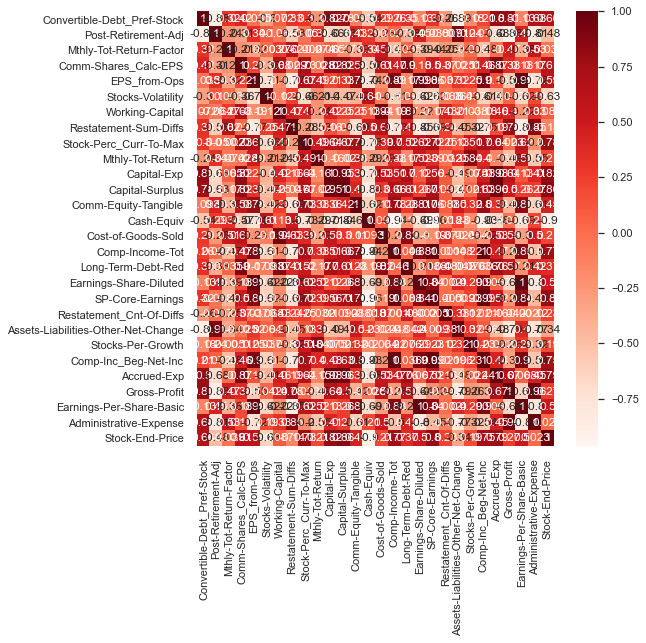

In [327]:
# Multiple Regressions -- Check for Correlations of Relevant Features Against Each
## Need to identify any collinear features
## Since many variables on this list are dummy variables, and corral is a subset of wave, I don't
### need to check for collinearity among those, just need to with age.
tempCLCheck = sev_Modeling.drop(columns=['severity'])

plt.figure(figsize=(8,8))
cor = round(tempCLCheck.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.savefig(plotLoc+'Collinear-Heatmap.png')

In [328]:
# Drop Highly Collinear Features
colsToDrop = ['Accrued-Exp','Capital-Exp','Cash-Equiv','Stock-End-Price', # many coll.
              'EPS_from-Ops','Earnings-Per-Share-Basic',# coll. w/ other eps
              'SP-Core-Earnings', # many coll.
              'Capital-Surplus', # coll. w/ Comm-Shares_Calc-EPS
              'Assets-Liabilities-Other-Net-Change', # collinear w/ Post-Retirement-Adj
              'Cost-of-Goods-Sold', # coll. w/ working capital
              'Long-Term-Debt-Red', # coll. w/ several incl working capital
              'Comp-Income-Tot',# coll. w/ eps diluted
              'Comp-Inc_Beg-Net-Inc', # coll. w/ eps diluted
              'Administrative-Expense', # coll. w/ gross-profit
              'Mthly-Tot-Return', # coll. w/ st_per_growth
            ]

    #'Capital-Exp','Intangible-Assets','Capital-Surplus','Nonoperating-Inc','Post-Retirement-Adj', # Many col.
                 # 'Operating-Act_Net-Cash-Flow', # Highly coll. w/  Debt-Current-Liabilities and others
                  #'Interest-Related-Exp', # highly coll. w/ interest paid
                  #'Debt-Current-Liabilities', # highly coll. w/ long term debt
                  #'Comp-Inc_Beg-Net-Inc', # highly coll. w/ pretax income
                  #'Depreciation-Amortization', # many coll.
                  #'Interest-Paid', # many coll.
                  #'Convertible-Debt_Pref-Stock', # highly coll. w/ long term debt
                  #'Sale-Prop-Plant-Equip-Inv', # many coll. mostly negative corr.
                  #'Administrative-Expense', # highly coll. with gross profit
                  #'Retained-Earnings', # highly coll. w/ pretax inc and
                  #'Cash', # highly coll w/ many

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Collinear Features"
df_name = "sev_Modeling"

#sev_Modeling = sev_Modeling.drop(columns=colsToDrop)
cleanActionsReport(sev_Modeling,df_name,cleanActionsDesc,colsToDrop)

,DF,ActionDesc,List-of-Cols,ResultShape
0,ModelingDF_orig,Original Shape,All,"(348, 161)"
1,ModelingDF,Dropped Standard Deviation Columns - Median Mo...,All STD Columns,"(348, 89)"
2,ModelingDF,Drop Rows w/ Null Settlement,All,"(46, 89)"
3,ModelingDF,Drop Lawsuit & Dismissed,Lawsuit/ Dismissed,"(11, 87)"
4,ModelingDF,Drop Features with less than 0.05 corr while m...,"[exesign, src, at, bkvlps, ch, dltt, dp, dpact...","(10, 63)"
5,sev_Modeling,Drop Features with less than 0.01 impDecrease,"[severity, dcpstk, dlc, prca, sec_trfm_mean, c...","(10, 34)"
6,sev_Modeling,Drop Features w/ low Correlation,"[lawsuit, Dismissed]","(10, 29)"
7,sev_Modeling,Drop Collinear Features,"[Accrued-Exp, Capital-Exp, Cash-Equiv, Stock-E...","(10, 29)"


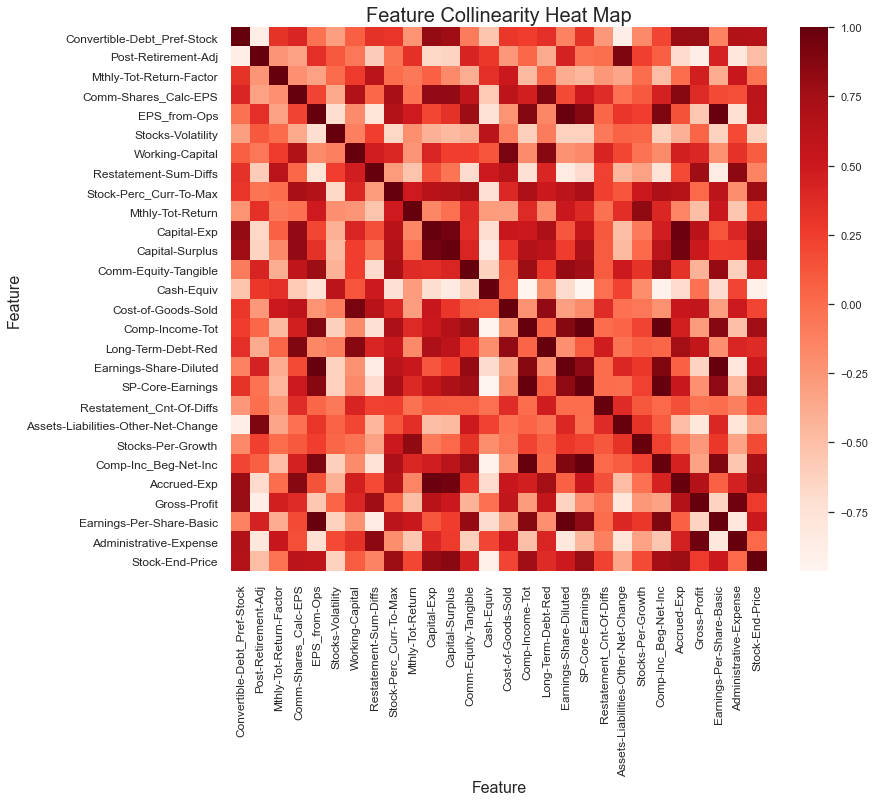

In [329]:
# Re-Check Collinearity
## Need to identify any collinear features
## Since many variables on this list are dummy variables, and corral is a subset of wave, I don't
### need to check for collinearity among those, just need to with age.
tempCLCheck = sev_Modeling.drop(columns=['severity'])

plt.figure(figsize=(12,10))
cor = round(tempCLCheck.corr(),3)
ax = sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
sns.set(font_scale=1)
ax.set_title("Feature Collinearity Heat Map", fontsize=20)
ax.set_ylabel("Feature", fontsize=16)
ax.set_xlabel("Feature", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig(plotLoc+'Collinear-Heatmap_re-check.png')


# Severity Modeling -- Modeling -- Initial Model Evaluation

Helpful overview:
 https://statisticsbyjim.com/regression/choosing-regression-analysis/#:~:text=Partial%20least%20squares%20(PLS)%20regression,independent%20variables%20are%20highly%20correlated.


In [330]:
# Multiple Regression -- Set or Reset Test/Train Split
# Params
df=sev_Modeling
ResponseVar = 'severity'
PredictorVar = df.columns.values.tolist()
PredictorVar.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar, ResponseVar)


## Severity Modeling -- Initial Model Evaluation -- Multiple Linear Regression

In [331]:
# Multiple Regression -- Set or Reset Test/Train Split

# Fit Mode
mr = LinearRegression()
mr.fit(x_train,y_train)

# Make Prediction
mr_yPred =  mr.predict(x_test)

In [332]:
# Multiple Regression -- Call Summary Function
# def summaryStats(regType,y_test,y_pred,SummaryDF):

regType = "Multiple-Regression-QE"
stats_y_test = y_test
stats_y_pred = mr_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-6.91,34929863437500.00,5910149.19
1,Multiple-Regression-QE,Multiple-Regression-QE,-22.02,101716161901937.00,10085443.07


## Severity Modeling -- Initial Model Evaluation -- Ridge Regression

In [333]:
# Ridge -- Create a set of alphas (same as lambdas) to be tested.
start = 0.01
stop = 100
alphas = np.linspace(start,stop,num=1000)

In [334]:
# Ridge -- Initialize Ridge Regression:
ridge = Ridge(normalize = True)

# Initialize rows and dataframe to store Results
row = []
coefs = []
ridgeResults = pd.DataFrame(columns = ["alpha","MSE"])

# Run Loop to Test Alphas
for a in alphas:
    alpha = a
    ridge.set_params(alpha = a)
    ridge.fit(x_train, y_train)
    coef = ridge.coef_
    coefs.append(ridge.coef_)
    pred = ridge.predict(x_test)
    MSE = round(mean_squared_error(y_test, pred),3)
    row = [alpha,MSE]
    df_length = len(ridgeResults)
    ridgeResults.loc[df_length] = row
ridgeResults.head()

,alpha,MSE
0,0.01,262414123472083.72
1,0.11,205826345154828.34
2,0.21,167407246485869.88
3,0.31,140029401375312.53
4,0.41,119773515961312.27


In [335]:
# print row with lowest MSE
rr_results = ridgeResults.loc[ridgeResults['MSE'].idxmin()]
rr_results

alpha                7.32
MSE     23969524558492.27
Name: 73, dtype: float64

In [336]:
# Ridge -- Re-run w/ best alpha

# Fit Model
ridge = Ridge(normalize = True)
ridge.set_params(alpha = 0.01)
ridge.fit(x_train, y_train)

# Make Prediction
ridge_yPred =  ridge.predict(x_test)

In [337]:
# Ridge-- predicting the accuracy score
regType = "Ridge-QE"
stats_y_test = y_test
stats_y_pred = ridge_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-6.91,34929863437500.00,5910149.19
1,Multiple-Regression-QE,Multiple-Regression-QE,-22.02,101716161901937.00,10085443.07
2,Ridge-QE,Ridge-QE,-58.40,262414123472083.72,16199201.32


### Lasso Regression

In [338]:
# Lasso Regression (using the same test/train split and alphas as Ridge Regression above)

#Initialize Lasso Regression:
lasso = Lasso(max_iter = 10000, normalize = True)

# Initialize rows and dataframe to store Results
row = []
coefs = []
lassoResults = pd.DataFrame(columns = ["alpha","MSE"])

# Run Loop to Test Alpas
for a in alphas:
    alpha = a
    lasso.set_params(alpha = a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)
    pred = lasso.predict(x_test)
    MSE = round(mean_squared_error(y_test, pred),3)
    row = [alpha,MSE]
    df_length = len(lassoResults)
    lassoResults.loc[df_length] = row
lassoResults.head()

,alpha,MSE
0,0.01,1450553480685822.00
1,0.11,1450544994130940.00
2,0.21,1450536507604140.50
3,0.31,1450528021105411.50
4,0.41,1450519534634764.50


In [339]:
# print row with lowest MSE
lasso_results = lassoResults.loc[lassoResults['MSE'].idxmin()]
lasso_results

alpha                 99.80
MSE     1214996753156376.00
Name: 997, dtype: float64

In [340]:
#Re-run w/ best alpha

#get best alpha as a variable
bestAlpha = round(lassoResults.loc[lassoResults['MSE'].idxmin(), 'alpha'],2)
alphas = [bestAlpha]

#Initialize Ridge Regression:
lasso = Lasso(max_iter = 10000, normalize = True)

# Initialize rows and dataframe to store Results
row = []
coefs = []
bestLassoResult = pd.DataFrame(columns = ["alpha","MSE"])

# Run Loop to Test Alphas
for a in alphas:
    alpha = a
    lasso.set_params(alpha = a)
    lasso.fit(x_train, y_train)
    lasso_yPred = lasso.predict(x_test)
    MSE = round(mean_squared_error(y_test, lasso_yPred),3)
    row = [alpha,MSE]
    df_length = len(bestLassoResult)
    bestLassoResult.loc[df_length] = row
bestLassoResult.head()

,alpha,MSE
0,99.80,1214996755177351.00


In [341]:
# Lasso --  Find the coefficients reduced to zero.
pd.Series(lasso.coef_, index=x_test.columns)

Convertible-Debt_Pref-Stock              1817168.35
Post-Retirement-Adj                   -255666135.76
Mthly-Tot-Return-Factor                   234459.27
Comm-Shares_Calc-EPS                    -1126172.17
EPS_from-Ops                                  -0.00
Stocks-Volatility                              0.00
Working-Capital                               -0.00
Restatement-Sum-Diffs                         -0.00
Stock-Perc_Curr-To-Max                         0.00
Mthly-Tot-Return                               0.00
Capital-Exp                             -4498193.44
Capital-Surplus                             -352.79
Comm-Equity-Tangible                    -3580444.93
Cash-Equiv                                     0.00
Cost-of-Goods-Sold                            -0.00
Comp-Income-Tot                         -6697558.15
Long-Term-Debt-Red                            -0.00
Earnings-Share-Diluted                        -0.00
SP-Core-Earnings                              -0.00
Restatement_

In [342]:
# Lasso -- predicting the accuracy score
regType = "Lasso-QE"
stats_y_test = y_test
stats_y_pred = lasso_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats


,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-6.91,34929863437500.00,5910149.19
1,Multiple-Regression-QE,Multiple-Regression-QE,-22.02,101716161901937.00,10085443.07
2,Ridge-QE,Ridge-QE,-58.40,262414123472083.72,16199201.32
3,Lasso-QE,Lasso-QE,-274.01,1214996755177351.00,34856803.57


### PLS Regression

In [343]:
# PLS - Fit Model

# PLS  -set length to length of training set
n = len(x_train)

# Set K Folds (to 10-fold) for CV
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=1)

#Initialize MSE list
mse = []

# Calculate MSE using CV for the 13 principle components, adding one component at the time.
upper = x_train.shape[1]

for i in np.arange(1, upper):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, x_train, y_train,
                                            cv=kf, scoring='neg_mean_squared_error').mean()
    mse.append(score)
mse

[6627067600598.371,
 2041288672199.3645,
 3508539198015.5107,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7368,
 2110448841349.7358,
 2110448841349.7358]

(-1.0, 28.3)

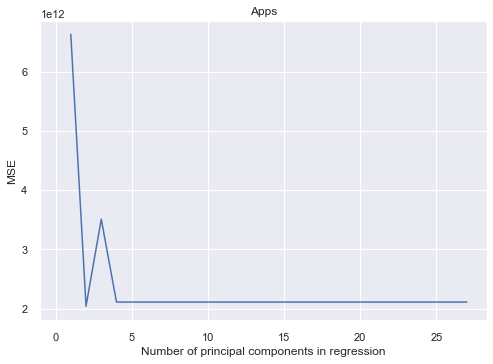

In [344]:
# PLS - Plot results
plt.plot(np.arange(1, upper), np.array(mse))
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Apps')
plt.xlim(xmin=-1)

In [345]:
# PLS -- Re-Run with the best result for M.
pls_m = 1
pls = PLSRegression(n_components=pls_m)
pls.fit(x_train, y_train)

pls_yPred = pls.predict(x_test)
pls_mse = round(mean_squared_error(y_test, pls_yPred),3)
bos_pls_rmse = round(math.sqrt(pls_mse),3)
print("MSE: ", bos_pls_rmse)

MSE:  5036729.311


In [346]:
# PLS -- predicting the accuracy score
regType = "PLS-QE"
stats_y_test = y_test
stats_y_pred = pls_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-6.91,34929863437500.00,5910149.19
1,Multiple-Regression-QE,Multiple-Regression-QE,-22.02,101716161901937.00,10085443.07
2,Ridge-QE,Ridge-QE,-58.40,262414123472083.72,16199201.32
3,Lasso-QE,Lasso-QE,-274.01,1214996755177351.00,34856803.57
4,PLS-QE,PLS-QE,-4.74,25368642150419.36,5036729.31


### Bagging

In [347]:
# Bagging -- Fit Model and Make Prediction:
bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=1000,
                            random_state=0,max_samples=0.8)
bagging.fit(X=x_train, y=y_train)

#Make Predictions
bagging_yPred = bagging.predict(x_test)
print("done")

done


In [348]:
# Bagging -- predicting the accuracy score
regType = "Bagging-QE"
stats_y_test = y_test
stats_y_pred = bagging_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats


,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-6.91,34929863437500.00,5910149.19
1,Multiple-Regression-QE,Multiple-Regression-QE,-22.02,101716161901937.00,10085443.07
2,Ridge-QE,Ridge-QE,-58.40,262414123472083.72,16199201.32
3,Lasso-QE,Lasso-QE,-274.01,1214996755177351.00,34856803.57
4,PLS-QE,PLS-QE,-4.74,25368642150419.36,5036729.31
5,Bagging-QE,Bagging-QE,-6.77,34317529188750.00,5858116.52


### RF Regressor

In [349]:
print("starting RF")
# Random Forest
## Set and Fit Model
## Note: Params from gridSearchCV optimized for recall w/ all features
rf = RandomForestRegressor(n_estimators=20, min_samples_split=2, min_samples_leaf=1,max_features='sqrt',
                           max_depth=10,bootstrap=True)
rf.fit(x_train,y_train)

## Make Predictions
y_pred_rf = rf.predict(x_test)
print("done RF")

starting RF
done RF


In [350]:
# Multiple Regression -- Call Summary Function

regType = "RF Regressor -- Feature Selection"
stats_y_test = y_test
stats_y_pred = y_pred_rf
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
print(f'r2 score is: ',Score)
print(f'mean_sqrd_error:',MSE)
print(f'root_mean_squared error:',RMSE)

r2 score is:  -5.868397170645446
mean_sqrd_error: 30344364062500.0
root_mean_squared error: 5508571.871410956


Start RF Feature Importance


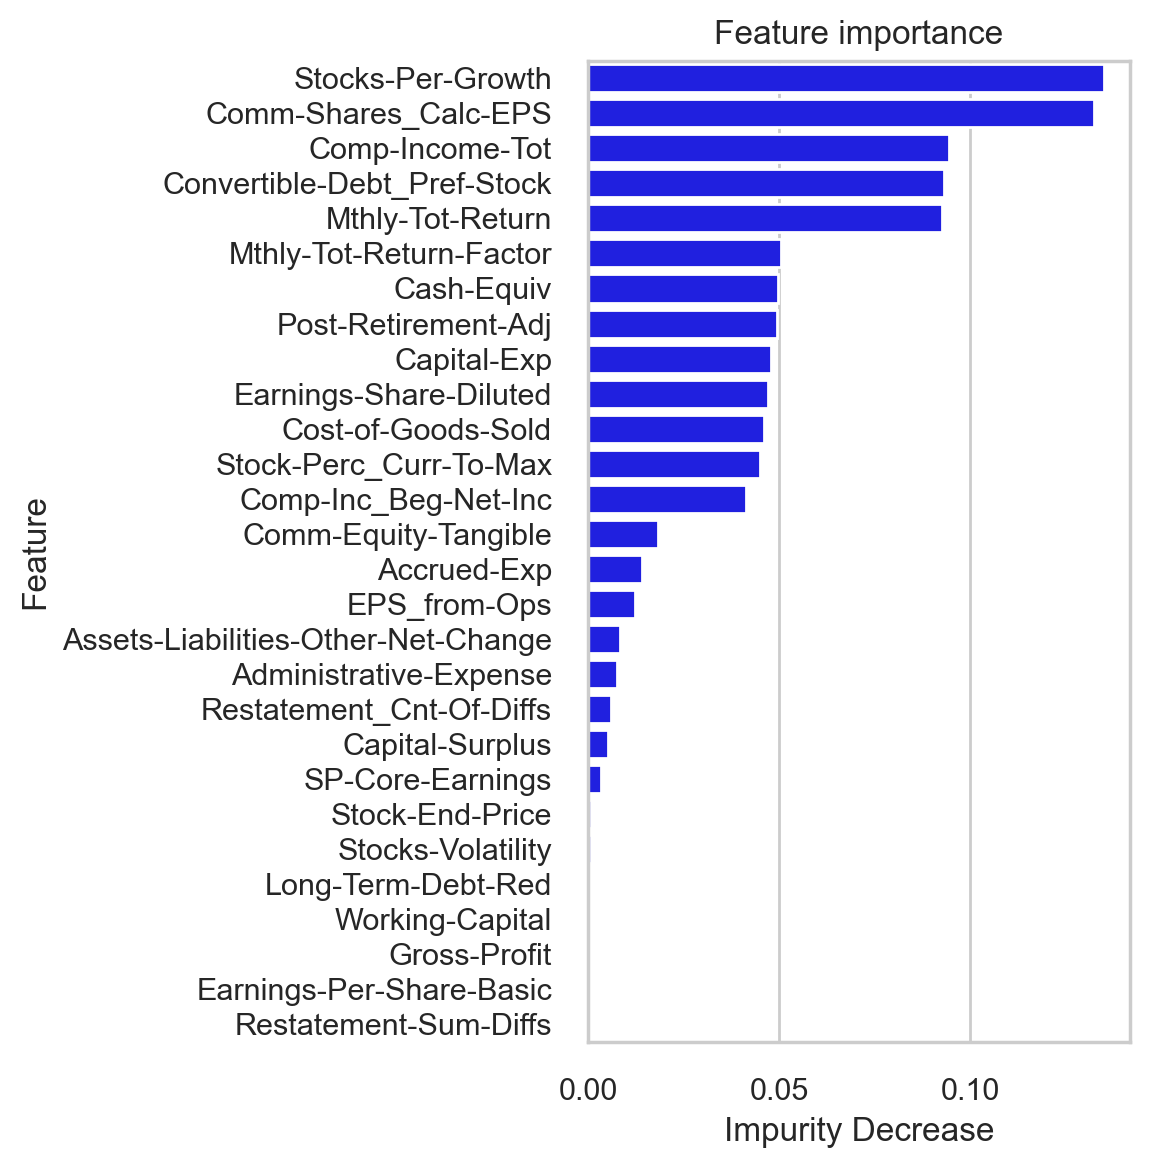

In [351]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF Feature Importance")
featureList = x_train.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Severity_FirstEval.png')


# Severity Modeling -- Modeling -- Selected Models:  PLS Regression

Be open to considering RF Regressor again


## Round 2: PLS Regression

guide: https://www.statology.org/partial-least-squares-in-python/

In [352]:
# PLS - Fit Model

# PLS  -set length to length of training set
n = len(x_train)

# Set K Folds (to 10-fold) for CV
kf = model_selection.KFold(n_splits=5,
                           shuffle=True,
                           random_state=1)

#Initialize MSE list
mse = []

# Calculate MSE using CV for the 13 principle components, adding one component at the time.
upper = x_train.shape[1]
upper = int((upper/2)+1)

for i in np.arange(1, upper):
    pls = PLSRegression(n_components=i,scale=False)
    score = -1*model_selection.cross_val_score(pls, x_train, y_train,
                                            cv=kf, scoring='neg_mean_squared_error').mean()
    mse.append(score)
mse
print("done")


done


(-1.0, 14.65)

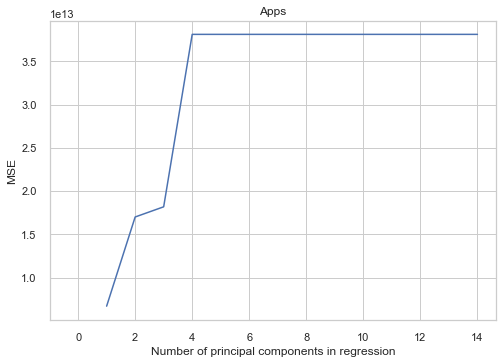

In [353]:
# PLS - Plot results
plt.plot(np.arange(1, upper), np.array(mse))
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Apps')
plt.xlim(xmin=-1)

In [354]:
# PLS -- Re-Run with the best result for M.
pls_m = 1
pls = PLSRegression(n_components=pls_m,
                    max_iter=50,
                    scale=True)
pls.fit(x_train, y_train)

pls_yPred = pls.predict(x_test)
pls_mse = round(mean_squared_error(y_test, pls_yPred),3)
pls_rmse = round(math.sqrt(pls_mse),3)
print("MSE: ", pls_mse)
print("RMSE: ", pls_rmse)
print("Done2")

MSE:  25368642150419.355
RMSE:  5036729.311
Done2


In [355]:
# PLS -- predicting the accuracy score
regType = "PLS-Round2"
stats_y_test = y_test
stats_y_pred = pls_yPred
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats



,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-6.91,34929863437500.00,5910149.19
1,Multiple-Regression-QE,Multiple-Regression-QE,-22.02,101716161901937.00,10085443.07
2,Ridge-QE,Ridge-QE,-58.40,262414123472083.72,16199201.32
3,Lasso-QE,Lasso-QE,-274.01,1214996755177351.00,34856803.57
4,PLS-QE,PLS-QE,-4.74,25368642150419.36,5036729.31
5,Bagging-QE,Bagging-QE,-6.77,34317529188750.00,5858116.52
6,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-5.87,30344364062500.00,5508571.87
7,PLS-Round2,PLS-Round2,-4.74,25368642150419.36,5036729.31


## Round 2: RF Regression


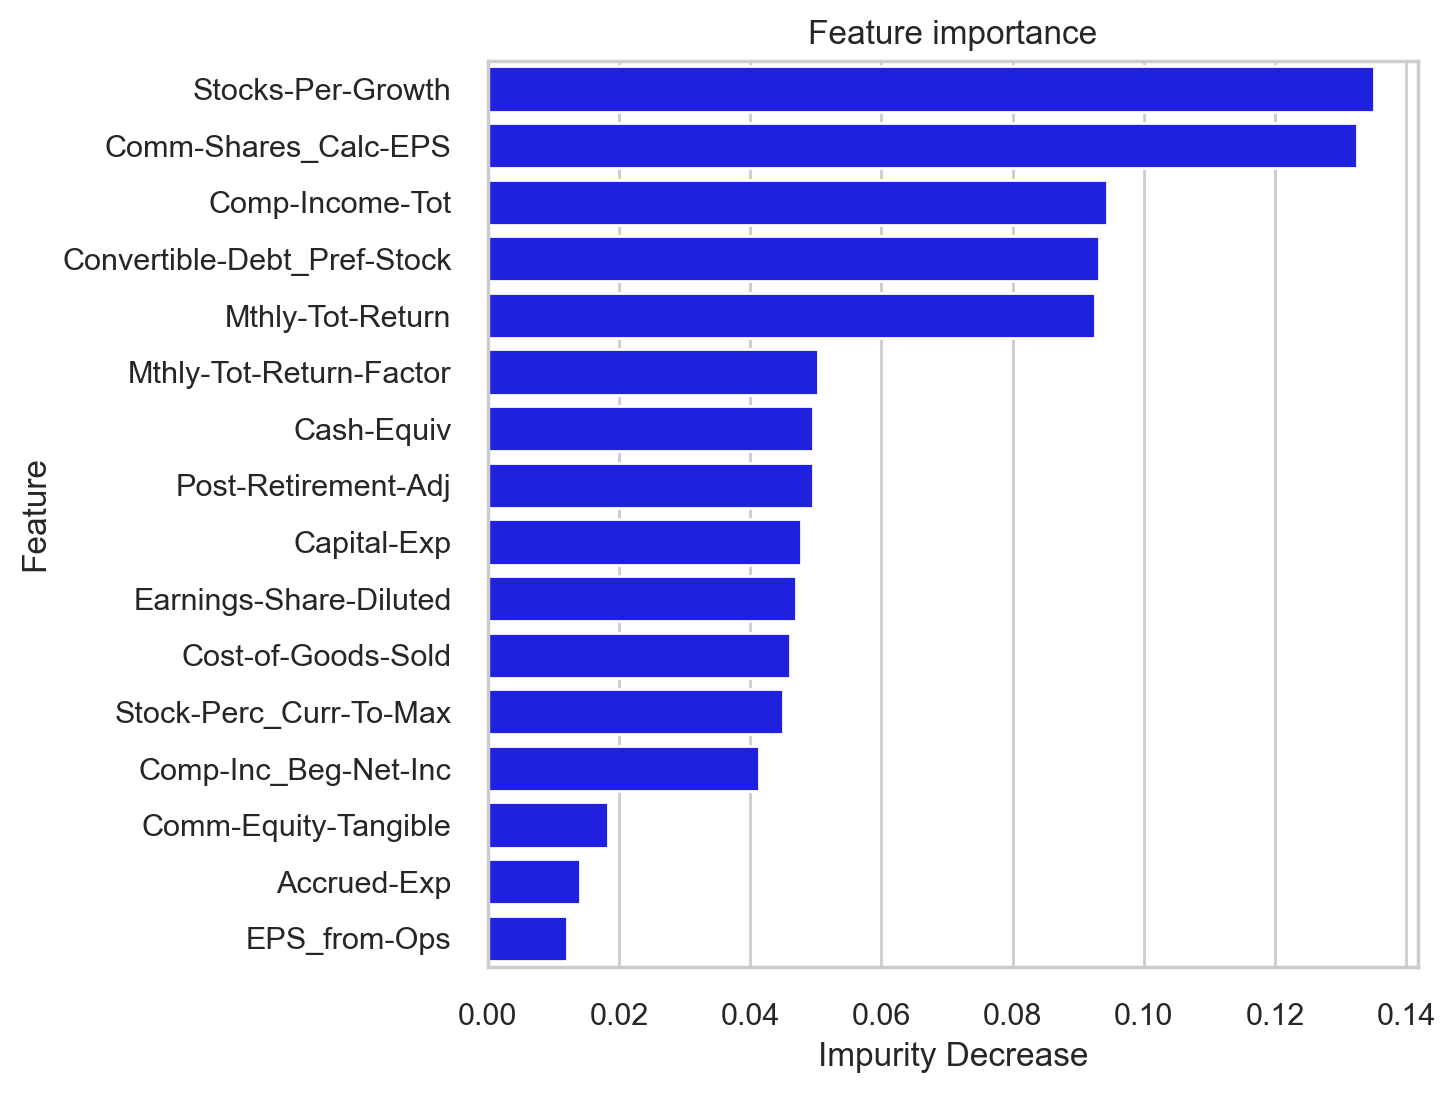

In [357]:
# drop these row indexes
# from dataFrame
index_names = feature_importances[feature_importances['impDecrease'] <= 0.01 ].index

# drop these row indexes
# from dataFrame
feature_importances.drop(index_names, inplace = True)
feature_importances

#featImport_ManAppend = {'feature': 'rat_spcsrc', 'impDecrease': 0.001111, 'Model': 'Manual Addition'}
#feature_importances = feature_importances.append(featImport_ManAppend,ignore_index=True)

# Create Plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (6,6), dpi=200)
ax = sns.barplot(x="impDecrease", y="feature",
                  data=feature_importances, color="blue")
#plt.vlines(x = 0.01, ymin = -1, ymax = 17.0, color = 'black', linewidth=1)
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Impurity Decrease")

plt.savefig(plotLoc +'Combined_LS_FeatSelect.png')

In [358]:
#featuresToKeep = feature_importances['feature'].values.tolist()
#x_test = x_test[featuresToKeep]
#x_train = x_train[featuresToKeep]

In [359]:
print("starting RF")
# Random Forest
## Set and Fit Model
## Note: Params from gridSearchCV optimized for recall w/ all features
rf = RandomForestRegressor(n_estimators=20, min_samples_split=2, min_samples_leaf=1,max_features='sqrt',
                           max_depth=10,bootstrap=True)
rf.fit(x_train,y_train)

## Make Predictions
y_pred_rf = rf.predict(x_test)
print("done RF")

starting RF
done RF


In [360]:
# Multiple Regression -- Call Summary Function

regType = "RF Regressor -- Feature Selection"
stats_y_test = y_test
stats_y_pred = y_pred_rf
summaryDF = quantStats

Score, MSE, RMSE  = summaryStats_quant(regType, stats_y_test, stats_y_pred,summaryDF)
quantStats

,Model,RegType,R2_Score,MSE,RMSE
0,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-6.91,34929863437500.00,5910149.19
1,Multiple-Regression-QE,Multiple-Regression-QE,-22.02,101716161901937.00,10085443.07
2,Ridge-QE,Ridge-QE,-58.40,262414123472083.72,16199201.32
3,Lasso-QE,Lasso-QE,-274.01,1214996755177351.00,34856803.57
4,PLS-QE,PLS-QE,-4.74,25368642150419.36,5036729.31
5,Bagging-QE,Bagging-QE,-6.77,34317529188750.00,5858116.52
6,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-5.87,30344364062500.00,5508571.87
7,PLS-Round2,PLS-Round2,-4.74,25368642150419.36,5036729.31
8,RF Regressor -- Feature Selection,RF Regressor -- Feature Selection,-6.14,31561114062500.00,5617927.92


Start RF Feature Importance


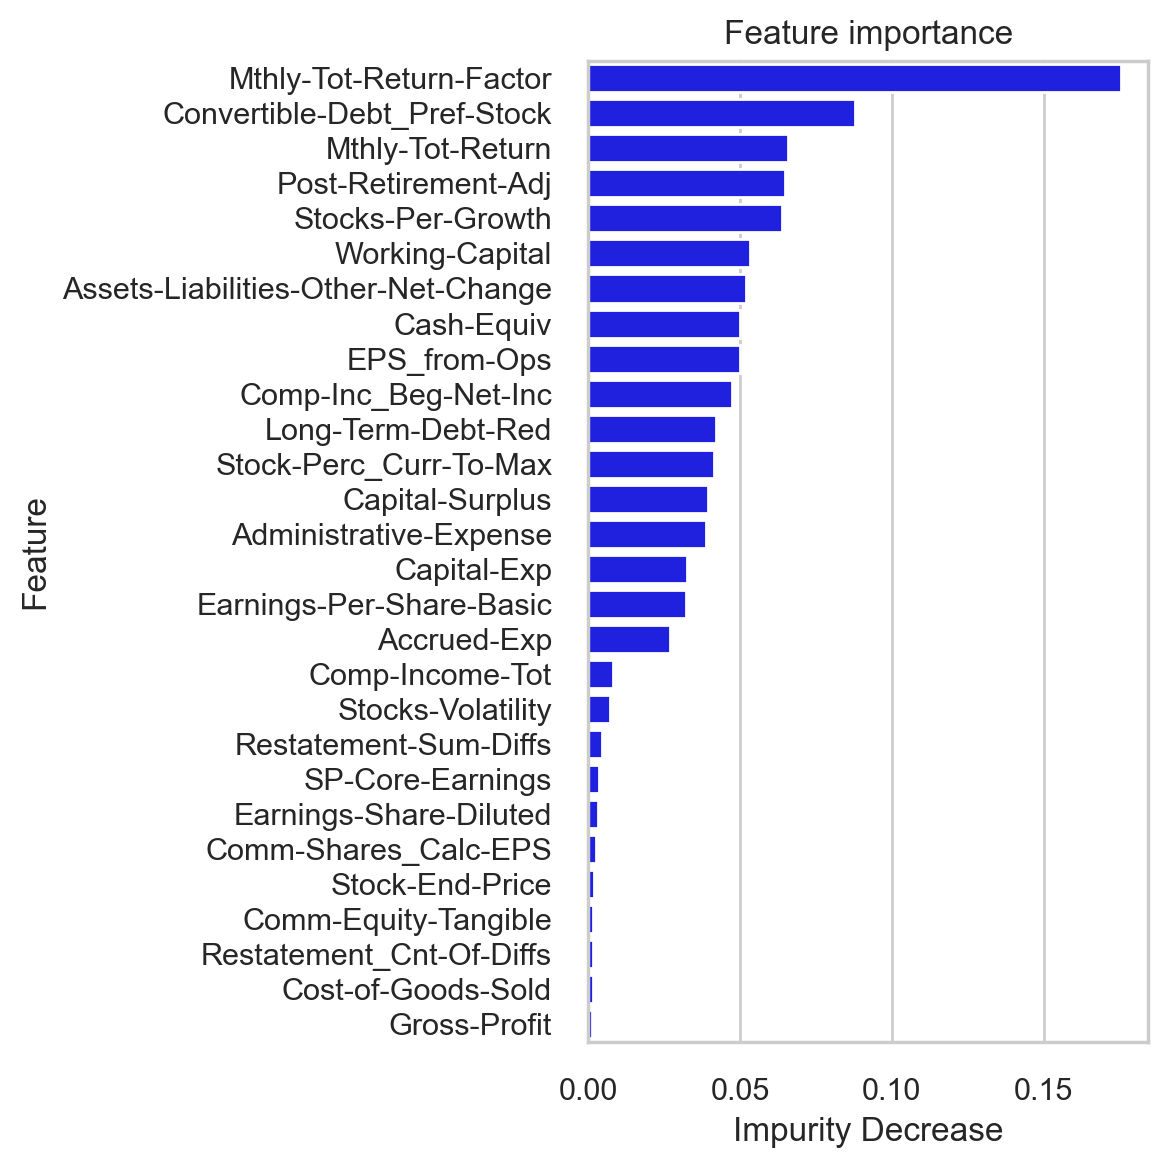

In [361]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF Feature Importance")
featureList = x_train.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Severity_FirstEval.png')


# Scoring


In [362]:
# Get BBC DAta into DF
sev_Modeling_bbc = ModelingDF_orig.loc[[61581]]

# rename variables
sev_Modeling_bbc = sev_Modeling_bbc.rename(columns=colsRename) # refers to rename dict from above

# Reduce BBC DF to same variables
colsToKeep = x_train.columns.to_list()
colsToKeep = colsToKeep + ['severity']
sev_Modeling_bbc = sev_Modeling_bbc[colsToKeep]
sev_Modeling_bbc

,Convertible-Debt_Pref-Stock,Post-Retirement-Adj,Mthly-Tot-Return-Factor,Comm-Shares_Calc-EPS,EPS_from-Ops,Stocks-Volatility,Working-Capital,Restatement-Sum-Diffs,Stock-Perc_Curr-To-Max,Mthly-Tot-Return,...,Restatement_Cnt-Of-Diffs,Assets-Liabilities-Other-Net-Change,Stocks-Per-Growth,Comp-Inc_Beg-Net-Inc,Accrued-Exp,Gross-Profit,Earnings-Per-Share-Basic,Administrative-Expense,Stock-End-Price,severity
gvkey,,,,,,,,,,,,,,,,,,,,,
61581,-0.19,0.05,-0.30,-0.40,0.00,0.48,-0.12,-0.13,0.85,-0.11,...,0,-0.02,3.77,-0.25,-0.27,-0.26,0.02,-0.24,0.99,nan


In [363]:
# split into X/Y
# Split Boston Beer Company into X/Y
x_bbc = sev_Modeling_bbc
x_bbc = x_bbc.drop(columns=('severity'))
y_bbc = sev_Modeling_bbc['severity']

In [364]:
# Make Predictions
y_pred_bbc = pls.predict(x_bbc)
print(f"Predicted Severity:",y_pred_bbc)


Predicted Severity: [[6525863.71066889]]


# Summary Visuals


In [365]:
# Create Complete DF
sev_Modeling_all = ModelingDF

# rename variables
sev_Modeling_all = sev_Modeling_all.rename(columns=colsRename) # refers to rename dict from above

# Reduce BBC DF to same variables
colsToKeep = x_train.columns.to_list()
colsToKeep = colsToKeep + ['severity']
sev_Modeling_all = sev_Modeling_all[colsToKeep]
sev_Modeling_all = pd.concat([sev_Modeling_all, sev_Modeling_bbc])
sev_Modeling_all

,Convertible-Debt_Pref-Stock,Post-Retirement-Adj,Mthly-Tot-Return-Factor,Comm-Shares_Calc-EPS,EPS_from-Ops,Stocks-Volatility,Working-Capital,Restatement-Sum-Diffs,Stock-Perc_Curr-To-Max,Mthly-Tot-Return,...,Restatement_Cnt-Of-Diffs,Assets-Liabilities-Other-Net-Change,Stocks-Per-Growth,Comp-Inc_Beg-Net-Inc,Accrued-Exp,Gross-Profit,Earnings-Per-Share-Basic,Administrative-Expense,Stock-End-Price,severity
gvkey,,,,,,,,,,,,,,,,,,,,,
3505,5.07,-0.09,-0.24,-0.09,-0.01,0.14,-0.08,-0.13,0.95,-0.13,...,1,-0.42,0.59,0.08,0.02,-0.09,-0.01,-0.10,0.16,6000000.00
5301,2.81,-0.09,0.25,-0.33,-0.28,1.08,0.19,-0.05,0.02,-0.21,...,2,-0.40,-0.97,-0.72,-0.18,0.03,-0.38,0.20,-0.23,9000000.00
7691,1.11,0.04,0.31,-0.40,-0.02,0.25,0.07,-0.11,0.63,-0.14,...,1,-0.08,-0.25,-0.27,-0.26,-0.25,-0.03,-0.23,-0.08,6750000.00
12785,-0.19,0.04,-0.23,-0.01,-0.07,0.57,0.50,-0.11,1.00,-0.11,...,11,0.17,2.40,-0.21,-0.11,-0.22,-0.07,-0.24,-0.06,1500000.00
20327,0.10,0.03,-0.00,-0.40,-0.08,0.71,-0.17,-0.13,0.62,0.02,...,0,-0.06,5.21,-0.29,-0.30,-0.29,-0.08,-0.27,-0.14,5750000.00
112968,-0.19,0.05,-0.25,-0.40,-0.10,1.00,-0.16,-0.13,0.35,-0.13,...,4,-0.03,2.98,-0.29,-0.29,-0.28,-0.09,-0.25,-0.16,11250000.00
114959,-0.19,0.05,-0.30,-0.39,-0.13,1.30,-0.15,-0.13,0.00,-0.16,...,0,-0.05,-1.00,-0.31,-0.30,-0.29,-0.13,-0.26,-0.23,2700000.00
149379,-0.19,0.05,-0.30,-0.38,-0.07,0.55,-0.11,-0.13,0.16,-0.14,...,1,-0.06,-0.69,-0.28,-0.30,-0.29,-0.07,-0.27,-0.22,2200000.00
163627,-0.19,-0.01,-0.29,-0.38,-0.09,0.51,-0.13,-0.10,0.29,-0.13,...,12,-0.08,-0.19,-0.31,-0.27,-0.27,-0.11,-0.25,-0.08,11000000.00


In [366]:
# split into X/Y
# Split Boston Beer Company into X/Y
x_all = sev_Modeling_all
x_all = x_all.drop(columns=('severity'))
y_all = sev_Modeling_all['severity']

In [367]:
# Make preditions for all
y_pred_all = pd.DataFrame(pls.predict(x_all))
y_pred_all

,0
0,9810910.37
1,11778608.78
2,6078310.39
3,746366.56
4,5404346.26
5,3714190.26
6,2949871.44
7,3792075.16
8,6262655.22
9,3679030.19


In [368]:
all_pred = pd.DataFrame(y_all).reset_index()
all_pred = all_pred.join(y_pred_all)
all_pred = all_pred.rename(columns={'severity':'actual(millions)',0:'predicted(millions)'})
all_pred['actual(millions)'] = all_pred['actual(millions)'].fillna(all_pred['predicted(millions)'])
all_pred['actual(millions)'] = all_pred['actual(millions)']/1000000
all_pred['predicted(millions)'] = all_pred['predicted(millions)']/1000000
all_pred['diff(millions'] = abs(all_pred['actual(millions)'] - all_pred['predicted(millions)'])
all_pred['Boston Beer Company'] = "No"
all_pred['Boston Beer Company'] = np.where(
        (all_pred['gvkey'] == 61581), "Yes", all_pred['Boston Beer Company'])
all_pred

,gvkey,actual(millions),predicted(millions),diff(millions,Boston Beer Company
0,3505,6.00,9.81,3.81,No
1,5301,9.00,11.78,2.78,No
2,7691,6.75,6.08,0.67,No
3,12785,1.50,0.75,0.75,No
4,20327,5.75,5.40,0.35,No
5,112968,11.25,3.71,7.54,No
6,114959,2.70,2.95,0.25,No
7,149379,2.20,3.79,1.59,No
8,163627,11.00,6.26,4.74,No
9,178795,3.75,3.68,0.07,No


In [380]:
from scipy.stats import percentileofscore
percentile_of_Sam = percentileofscore(all_pred['predicted(millions)'], 6.53)
percentile_of_Sam

81.81818181818181

<AxesSubplot:xlabel='predicted(millions)', ylabel='Density'>

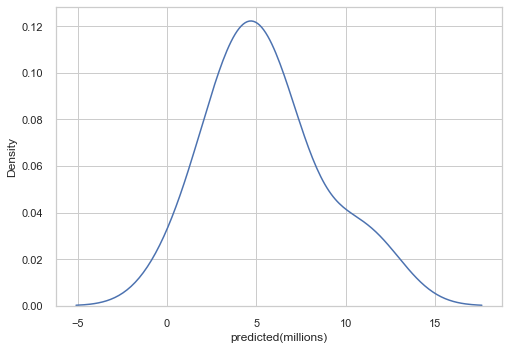

In [375]:
sns.kdeplot(data=all_pred,x='predicted(millions)')

In [370]:
# Get 95% Confidence Range:
meanPred = round(all_pred['predicted(millions)'].mean(),2)
print(f"mean prediction:",meanPred)

stdPred = round(all_pred['predicted(millions)'].std(),2)
print(f"standard deviation:",stdPred)

#pointEstimate for BBC
pointEstBBC = round(all_pred.loc[all_pred['gvkey'] == 61581,"predicted(millions)"].values[0],2)
print(f"BBC point estimate:",pointEstBBC)

#z-Score -- z-score for 95% is 1.96, 80% is 1.28, 90 is 1.645
interval_zscore = 1.645
print(f"z score for interval level:",interval_zscore)

lowerRange = round(pointEstBBC - interval_zscore*stdPred,2)
upperRange = round(pointEstBBC + interval_zscore*stdPred,2)
print(f"90% interval range:",lowerRange, "-", upperRange)

mean prediction: 5.52
standard deviation: 3.14
BBC point estimate: 6.53
z score for interval level: 1.645
90% interval range: 1.36 - 11.7


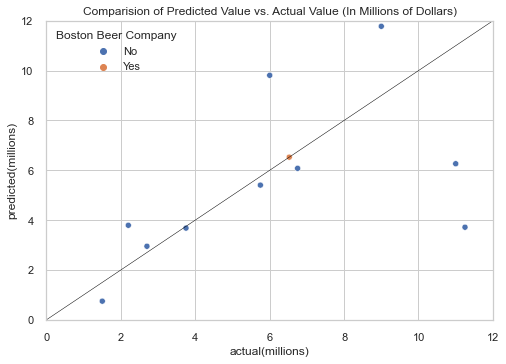

In [371]:
# scatterplot of predicted vs. actual
ax = sns.scatterplot(data=all_pred, x="actual(millions)", y="predicted(millions)",
                hue="Boston Beer Company")
ax.set(xlim=(0,12),ylim=(0,12))
plt.title('Comparision of Predicted Value vs. Actual Value (In Millions of Dollars)')
ax.axline((0, 0), (1, 1), linewidth=0.5, color='black')

In [372]:
data = all_pred

scatter1 = px.scatter(data, y='predicted(millions)', x='actual(millions)',color="Boston Beer Company",
                      width=600, height=600,
                      opacity= 1,
                      template="seaborn",
                      labels={
                         "predicted(millions)": "Predicted Value (Millions of Dollars)",
                         "actual(millions)": "Actual Value (Millions of Dollars)",
                         },
                )

scatter1.update_traces(marker=dict(size=10,
                                   line=dict(width=2,
                                             color='Black')),
                  selector=dict(mode='markers'))

scatter1.add_shape(type="line",
    x0=0, y0=0, x1=16, y1=16,
    line=dict(
        color="blue",
        width=2,
    )
)

scatter1.add_annotation(x=12, y=11.95,
            text="Correct Prediction",
            showarrow=False,
                        textangle=309,
            yshift=10)

scatter1.add_annotation(x=2, y=13.7,
            text="Over Predicted",
            showarrow=False)
            #yshift=10)

scatter1.add_annotation(x=12, y=0,
            text="Under Predicted",
            showarrow=False,
            yshift=10)

scatter1.update_layout(
    title={
        'text': "Predicted Value vs. Actual Value (in Millions of Dollars)",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'auto'},
     xaxis = dict(
        tick0 = 0,
         dtick=2,
         rangemode = "tozero",
         range=[0,14],
        tickformat = '$,'),
     yaxis = dict(
         tickmode = 'linear',
         dtick = 2,
         rangemode = "tozero",
         range=[0,14],
         tickformat = '$,')
)
scatter1.show()
plt.savefig(plotLoc+'Prediction-Summary.png')

<Figure size 576x396 with 0 Axes>

In [392]:
# Create a x/y test of test + bbc

x_test_wBBC = x_test.append(x_bbc)
y_test_wBBC = y_test.append(y_bbc)
y_pred_wBBC = pd.DataFrame(pls.predict(x_test_wBBC))

,0
0,6262655.22
1,11778608.78
2,3714190.26
3,9810910.37
4,6525863.71


In [396]:
test_wBBC = pd.DataFrame(y_test_wBBC).reset_index()
test_wBBC = test_wBBC.join(y_pred_wBBC)
test_wBBC = test_wBBC.rename(columns={'severity':'actual(millions)',0:'predicted(millions)'})
test_wBBC['actual(millions)'] = test_wBBC['actual(millions)'].fillna(test_wBBC['predicted(millions)'])
test_wBBC['actual(millions)'] = test_wBBC['actual(millions)']/1000000
test_wBBC['predicted(millions)'] = test_wBBC['predicted(millions)']/1000000
test_wBBC['diff(millions'] = abs(test_wBBC['actual(millions)'] - test_wBBC['predicted(millions)'])
test_wBBC['Boston Beer Company'] = "No"
test_wBBC['Boston Beer Company'] = np.where(
        (test_wBBC['gvkey'] == 61581), "Yes", test_wBBC['Boston Beer Company'])
test_wBBC


,gvkey,actual(millions),predicted(millions),diff(millions,Boston Beer Company
0,163627,11.00,6.26,4.74,No
1,5301,9.00,11.78,2.78,No
2,112968,11.25,3.71,7.54,No
3,3505,6.00,9.81,3.81,No
4,61581,6.53,6.53,0.00,Yes


In [ ]:
# plot differences in predictions


In [403]:
data = test_wBBC

scatter1 = px.scatter(data, y='predicted(millions)', x='actual(millions)',color="Boston Beer Company",
                      width=600, height=600,
                      opacity= 1,
                      template="seaborn",
                      labels={
                         "predicted(millions)": "Predicted Value (Millions of Dollars)",
                         "actual(millions)": "Actual Value (Millions of Dollars)",
                         },
                )

scatter1.update_traces(marker=dict(size=10,
                                   line=dict(width=2,
                                             color='Black')),
                  selector=dict(mode='markers'))

scatter1.add_shape(type="line",
    x0=0, y0=0, x1=16, y1=16,
    line=dict(
        color="blue",
        width=2,
    )
)

scatter1.add_annotation(x=12, y=11.95,
            text="Correct Prediction",
            showarrow=False,
                        textangle=309,
            yshift=10)

scatter1.add_annotation(x=2, y=13.7,
            text="Over Predicted",
            showarrow=False)
            #yshift=10)

scatter1.add_annotation(x=12, y=0,
            text="Under Predicted",
            showarrow=False,
            yshift=10)

scatter1.update_layout(
    title={
        'text': "Predicted Value vs. Actual Value (in Millions of Dollars)<br><sup>Test Set w/ Boston Beer Company</sup>",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'auto'},
     xaxis = dict(
        tick0 = 0,
         dtick=2,
         rangemode = "tozero",
         range=[0,14],
        tickformat = '$,'),
     yaxis = dict(
         tickmode = 'linear',
         dtick = 2,
         rangemode = "tozero",
         range=[0,14],
         tickformat = '$,')
)
scatter1.show()
plt.savefig('Prediction-Summary_testwBBC.png')



<Figure size 576x396 with 0 Axes>

# Exports

In [373]:
quantStats.to_excel(exportPath+"Model-Eval.xlsx")
all_pred.to_excel(exportPath+"Predictions.xlsx")

# Model Tuning

In [374]:
break

SyntaxError: 'break' outside loop (<ipython-input-374-d96a1d1b8682>, line 1)

## RF Tuning -- MSE
using this as a guide:
https://www.kaggle.com/code/arjunprasadsarkhel/simple-random-forest-with-hyperparameter-tuning/notebook

In [ ]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

rf_tuning = RandomForestRegressor()

In [ ]:
print("starting...")
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf_tuning,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
print("Done")

In [ ]:
rf_random.fit(x_train, y_train)

In [ ]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

## PLS Tuning -- MSE
using this as a guide:

In [ ]:
pls.get_params()
pls.get_params().keys()

In [ ]:
max_iter = [50,100,250,500,750,1000] # number of trees in the random forest
scale = ['True', 'False'] # number of features in consideration at every split
copy = ['True', 'False'] # maximum number of levels allowed in each decision tree

random_grid = {'max_iter': max_iter,
               'scale': scale,
               'copy': copy,}

pls_tuning = PLSRegression()

In [ ]:
print("starting...")
from sklearn.model_selection import RandomizedSearchCV
pls_random = RandomizedSearchCV(estimator = pls_tuning,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
print("Done")

In [ ]:
pls_random.fit(x_train, y_train)

In [ ]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', pls_random.best_params_, ' \n')

In [ ]:
pls.get_params()
